# Data

## Dataset

In [1]:
import os
import json
import torch
import random
from datetime import datetime
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import savgol, minmax_scaler

label_names = ['AA_SN_X', 'AA_SN_Y', 'AA_SN_Z', 'GH_AA_X', 'GH_AA_Y', 'GH_AA_Z']

class Sensor2AngleDataset(Dataset):
    def __init__(self, dataDir, windowLength):
        self.dataDir = dataDir
        self.windowLength = windowLength
        self.data = self.load_data(dataDir, windowLength)   
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sensorSample, angleSample = self.data[index]
        return sensorSample, angleSample
    
    def load_data(self, dataDir, windowLength, doStandardize=True, doFilter=True):
        sensorPath = Path(dataDir) / "sensor.npy"
        anglePath = Path(dataDir) / "angle.npy"
        with open(sensorPath, 'rb') as f:
            sensorAll = np.load(f)
        with open(anglePath, 'rb') as f:
            angleAll = np.load(f)
        assert sensorAll.shape[0] == angleAll.shape[0]
        if doStandardize:
            sensorAll = self.standardize_sensor(sensorAll)
        if doFilter:
            sensorAll, angleAll = self.filter_sensor_and_angle(sensorAll, angleAll)
        sensorWindowsAll, angleWindowsAll = self.sliding_window(sensorAll, angleAll, windowLength)
        datasetList = []
        for sensorSample, angleSample in zip(sensorWindowsAll, angleWindowsAll):
            datasetList.append([sensorSample, angleSample]) 
        return datasetList
    
    def standardize_sensor(self, sensorAll):
        print(sensorAll.shape)
        sensorAllStd = np.array(list(map(minmax_scaler, sensorAll)))
        # time-wise standardize
#         scalerStd = StandardScaler()
#         sensorStd = scalerStd.fit_transform(sensorAll)
        return sensorAllStd

    def filter_sensor_and_angle(self, sensorAll, angleAll, do_plot=False):
        for i in range(sensorAll.shape[1]):
            title = f'sensor_{i}'
            sensorAll[:,i] = savgol(sensorAll[:,i], 51, 2, title=title, do_plot=do_plot)
        angleFlt = []
        for i in range(angleAll.shape[1]):
            title = label_names[i]
            angleAll[:,i] = savgol(angleAll[:,i], 51, 2, title=title, do_plot=do_plot)
        return sensorAll, angleAll
    
    def sliding_window(self, sensorAll, angleAll, windowLength):
        senserAllWindows = []
        angleAllWindows = []
        assert(sensorAll.shape[0] == angleAll.shape[0])
        numSample = sensorAll.shape[0]
        for i in range(numSample-windowLength+1):
            _x = sensorAll[i:(i+windowLength)]
            _y = angleAll[i+windowLength-1]
            senserAllWindows.append(_x)
            angleAllWindows.append(_y) 
        return senserAllWindows, angleAllWindows
    
    
    
class Sensor2AngleTestDataset(Dataset):
    def __init__(self, dataDir, windowLength):
        self.dataDir = dataDir
        self.windowLength = windowLength
        self.data = self.load_data(dataDir, windowLength)   
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sensorSample = self.data[index]
        return sensorSample
    
    def load_data(self, dataDir, windowLength, doStandardize=True, doFilter=True):
        sensorPath = Path(dataDir)
        with open(sensorPath, 'rb') as f:
            sensorAll = np.load(f)
        if doStandardize:
            sensorAll = self.standardize_sensor(sensorAll)
        if doFilter:
            sensorAll = self.filter_sensor(sensorAll)
        sensorWindowsAll = self.sliding_window(sensorAll, windowLength)
        return sensorWindowsAll
    
    def standardize_sensor(self, sensorAll):
        # TODO
        print(sensorAll.shape)
        sensorAllStd = np.array(list(map(minmax_scaler, sensorAll)))
        return sensorAllStd

    def filter_sensor(self, sensorAll, do_plot=False):
        for i in range(sensorAll.shape[1]):
            title = f'sensor_{i}'
            sensorAll[:,i] = savgol(sensorAll[:,i], 51, 2, title=title, do_plot=do_plot)
        return sensorAll
    
    def sliding_window(self, sensorAll, windowLength):
        senserAllWindows = []
        numSample = sensorAll.shape[0]
        for i in range(numSample-windowLength+1):
            _x = sensorAll[i:(i+windowLength)]
            senserAllWindows.append(_x)
        return senserAllWindows

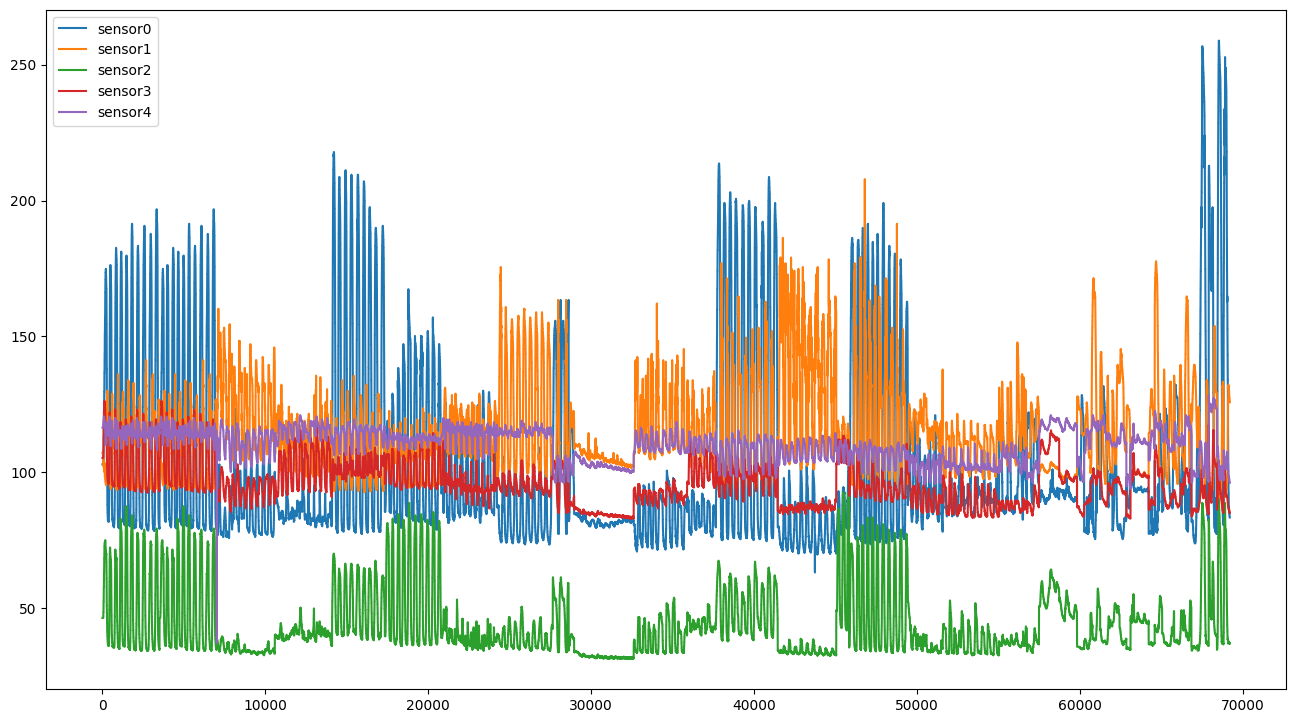

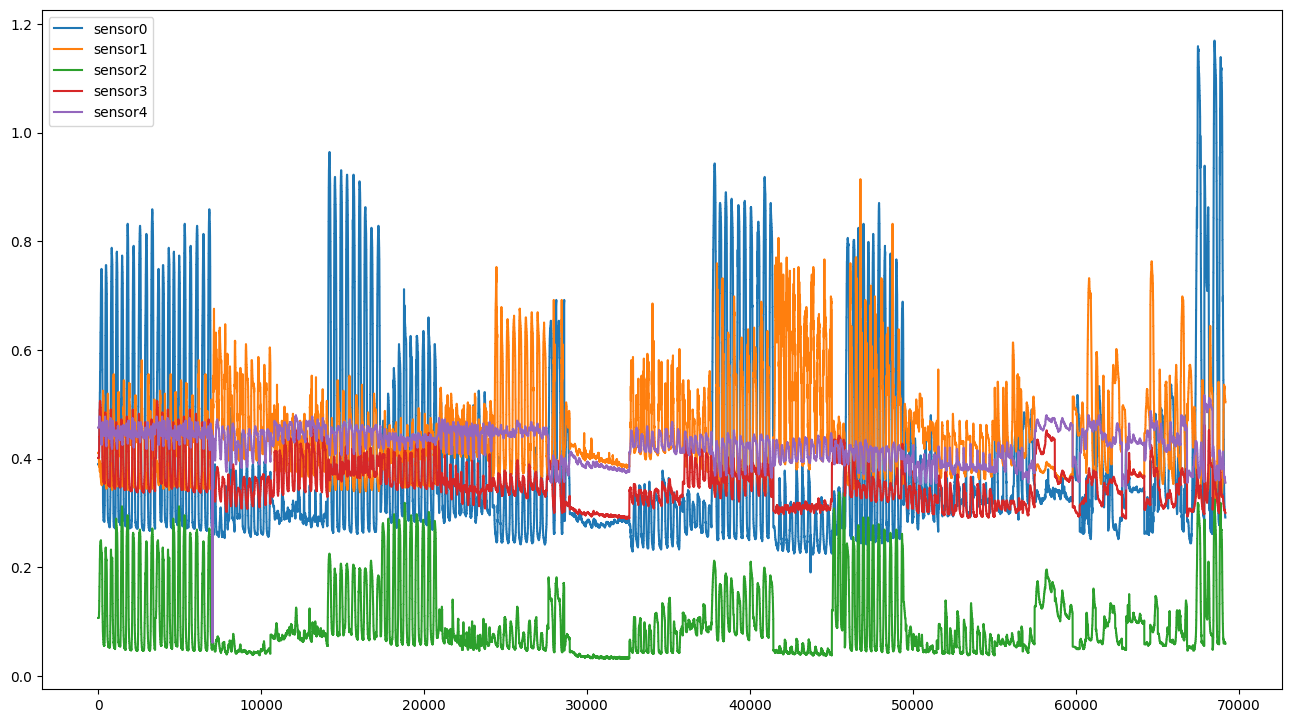

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def compare_standarize_methods(dataDir='./data/trainset/'):
    sensorPath = Path(dataDir) / "sensor.npy"
    with open(sensorPath, 'rb') as f:
        sensorAll = np.load(f)
    figure(figsize=(16, 9), dpi=100)
    for i in range(5):
        plt.plot(sensorAll[:,i], label=f'sensor{i}')
    plt.legend()
    plt.show()
    
    
    sensorAllStd = np.array(list(map(minmax_scaler, sensorAll)))
    figure(figsize=(16, 9), dpi=100)
    for i in range(5):
        plt.plot(sensorAllStd[:,i], label=f'sensor{i}')
    plt.legend()
    plt.show()
    
compare_standarize_methods()

## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.

In [3]:
import torch
from torch.utils.data import DataLoader, random_split

def collate_batch(batch):
    # Process features within a batch.
    """Collate a batch of data."""
    sensor, angle = zip(*batch)
    return torch.FloatTensor(sensor), torch.FloatTensor(angle)


def get_dataloader(data_dir, windowLength, batch_size, n_workers):
    """Generate dataloader"""
    dataset = Sensor2AngleDataset(data_dir, windowLength)
    # Split dataset into training dataset and validation dataset
    trainlen = int(0.9 * len(dataset))
    lengths = [trainlen, len(dataset) - trainlen]
    trainset, validset = random_split(dataset, lengths)
    
    train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=collate_batch,
    )
    valid_loader = DataLoader(
    validset,
    batch_size=batch_size,
    num_workers=n_workers,
    drop_last=True,
    pin_memory=False,
    collate_fn=collate_batch,
    )
    return train_loader, valid_loader

In [4]:
train_loader, valid_loader = get_dataloader('./data/trainset/', 32, 64, 0)
for index, data in enumerate(train_loader):
    print(data[0].size())
    break

(69193, 5)
torch.Size([64, 32, 5])


# Model
- TransformerEncoderLayer:
  - Base transformer encoder layer in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
  - Parameters:
    - d_model: the number of expected features of the input (required).

    - nhead: the number of heads of the multiheadattention models (required).

    - dim_feedforward: the dimension of the feedforward network model (default=2048).

    - dropout: the dropout value (default=0.1).

    - activation: the activation function of intermediate layer, relu or gelu (default=relu).

- TransformerEncoder:
  - TransformerEncoder is a stack of N transformer encoder layers
  - Parameters:
    - encoder_layer: an instance of the TransformerEncoderLayer() class (required).

    - num_layers: the number of sub-encoder-layers in the encoder (required).

    - norm: the layer normalization component (optional).

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, d_channel, d_temporal, window_length, dropout):
        super().__init__()
        # Project the dimension of features from that of input into d_model.
        self.channelEncoder = nn.Linear(5, d_channel)
        self.temporalEncoder = nn.Linear(window_length, d_temporal)
        # TODO:
        #   Change Transformer to Conformer.
        #   https://arxiv.org/abs/2005.08100
        self.channelwiseAttentionLayer = nn.TransformerEncoderLayer(
          d_model=window_length, dim_feedforward=512, nhead=8, dropout=dropout
        )
        self.temporalwiseAttentionLayer = nn.TransformerEncoderLayer(
          d_model=d_temporal, dim_feedforward=512, nhead=8, dropout=dropout
        )
        self.predLayer = nn.Sequential(
          nn.Linear(d_temporal, d_temporal),
          nn.ReLU(),
          nn.Linear(d_temporal, 6),
        )

    def forward(self, sensors):
        """
        args:
          sensors: (batch size, length, 5)
        return:
          out: (batch size, angles)
        """
        # input: (batch size, length, 5)
        # out: (batch size, length, d_channel)
        out = self.channelEncoder(sensors)
        # The encoder layer expect features in the shape of (args, batch size, args).
        # out: (d_channel, batch size, length)
        out = out.permute(2, 0, 1)
        # out: (d_channel, batch size, length)
        out = self.channelwiseAttentionLayer(out)
        # out: (batch size, d_channel, length)
        out = out.permute(1, 0, 2)
        # out: (batch size, d_channel, d_temporal)
        out = self.temporalEncoder(out)
        # out: (batch size, d_channel, d_temporal)
        out = self.temporalwiseAttentionLayer(out)
        # mean pooling
        stats = out.mean(dim=1)
        # out: (batch, n_output)
        out = self.predLayer(stats)
        return out


from torchinfo import summary
print(summary(Attention(d_channel=128, d_temporal=32, window_length=32, dropout=0.1), input_size=(64, 32, 5)))

Layer (type:depth-idx)                   Output Shape              Param #
Attention                                --                        --
├─Linear: 1-1                            [64, 32, 128]             768
├─TransformerEncoderLayer: 1-2           [128, 64, 32]             --
│    └─MultiheadAttention: 2-1           [128, 64, 32]             --
│    └─Dropout: 2-2                      [128, 64, 32]             --
│    └─LayerNorm: 2-3                    [128, 64, 32]             64
│    └─Linear: 2-4                       [128, 64, 512]            16,896
│    └─Dropout: 2-5                      [128, 64, 512]            --
│    └─Linear: 2-6                       [128, 64, 32]             16,416
│    └─Dropout: 2-7                      [128, 64, 32]             --
│    └─LayerNorm: 2-8                    [128, 64, 32]             64
├─Linear: 1-3                            [64, 128, 32]             1,056
├─TransformerEncoderLayer: 1-4           [64, 128, 32]             --
│  

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLSTM(nn.Module):
    def __init__(self, d_channel, d_temporal, window_length, dropout):
        super().__init__()
        self.channelEncoder = nn.Linear(5, d_channel)
        self.channelwiseAttentionLayer = nn.TransformerEncoderLayer(
          d_model=window_length, dim_feedforward=512, nhead=8, dropout=dropout
        )
        self.temporalwiseAttentionLayer = nn.TransformerEncoderLayer(
          d_model=d_temporal, dim_feedforward=512, nhead=8, dropout=dropout
        )
        self.predLayer = nn.Sequential(
          nn.Linear(d_temporal, d_temporal),
          nn.ReLU(),
          nn.Linear(d_temporal, 6),
        )

    def forward(self, sensors):
        """
        args:
          sensors: (batch size, length, 5)
        return:
          out: (batch size, angles)
        """
        # input: (batch size, length, 5)
        # out: (batch size, length, d_channel)
        out = self.channelEncoder(sensors)
        # The encoder layer expect features in the shape of (args, batch size, args).
        # out: (d_channel, batch size, length)
        out = out.permute(2, 0, 1)
        # out: (d_channel, batch size, length)
        out = self.channelwiseAttentionLayer(out)
        # out: (batch size, d_channel, length)
        out = out.permute(1, 0, 2)
        # out: (batch size, d_channel, d_temporal)
        out = self.temporalEncoder(out)
        # out: (batch size, d_channel, d_temporal)
        out = self.temporalwiseAttentionLayer(out)
        # mean pooling
        stats = out.mean(dim=1)
        # out: (batch, n_output)
        out = self.predLayer(stats)
        return out


from torchinfo import summary
print(summary(Attention(d_channel=128, d_temporal=32, window_length=32, dropout=0.1), input_size=(64, 32, 5)))

# Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [12]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
  optimizer: Optimizer,
  num_warmup_steps: int,
  num_training_steps: int,
  num_cycles: float = 0.5,
  last_epoch: int = -1,
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
    optimizer (:class:`~torch.optim.Optimizer`):
      The optimizer for which to schedule twhe learning rate.
    num_warmup_steps (:obj:`int`):
      The number of steps for the warmup phase.
    num_training_steps (:obj:`int`):
      The total number of training steps.
    num_cycles (:obj:`float`, `optional`, defaults to 0.5):
      The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
      following a half-cosine).
    last_epoch (:obj:`int`, `optional`, defaults to -1):
      The index of the last epoch when resuming training.

    Return:
    :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step):
        # Warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
          max(1, num_training_steps - num_warmup_steps)
        )
        return max(
          0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)

# Model Function
- Model forward function.

In [13]:
import torch


def model_fn(batch, model, criterion, device):
    """Forward a batch through the model."""
    mels, labels = batch
    mels = mels.to(device)
    labels = labels.to(device)
    outs = model(mels)
    loss = criterion(outs, labels)
    
    return loss

In [14]:
# train_loader, valid_loader = get_dataloader(data_dir='./data',
#                                             windowLength=120, 
#                                             batch_size=32, 
#                                             n_workers=0)
# train_iterator = iter(train_loader)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Attention().to(device)
# batch = next(train_iterator)
# mels, labels = batch
# mels = mels.to(device)
# labels = labels.to(device)

# outs = model(mels)

# Validate
- Calculate mse_loss of the validation set.

In [15]:
from tqdm import tqdm
import torch


def valid(dataloader, model, criterion, device): 
    """Validate on validation set."""
    model.eval()
    running_loss = 0.0
    pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")

    for i, batch in enumerate(dataloader):
        with torch.no_grad():
            loss = model_fn(batch, model, criterion, device)
            running_loss += loss.item()


        pbar.update(dataloader.batch_size)
        pbar.set_postfix(
        loss=f"{running_loss / (i+1):.2f}")

    pbar.close()
    model.train()

    return running_loss / len(dataloader)

# Train

In [16]:
# from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split

# Attention(d_channel=128, d_temporal=32, window_length=32, dropout=0.1), input_size=(64, 32, 5))

def parse_args():
    """arguments"""
    config = {
    "data_dir": "./data/trainset/",
    "save_path": f"model/channel_temporal_attention-{datetime.now().strftime('%Y-%m-%d-%H-%M')}.ckpt",
        
    "window_length": 32,
    "d_channel": 128, 
    "d_temporal": 32,
    "dropout": 0.1,
    "batch_size": 32,
    
    "n_workers": 0,
    "valid_steps": 2000,
    "warmup_steps": 1000,
    "save_steps": 10000,
    "total_steps": 1000000,
    }

    return config


def main(
    data_dir,
    save_path,
    window_length,
    d_channel,
    d_temporal,
    dropout,
    batch_size,
    n_workers,
    valid_steps,
    warmup_steps,
    total_steps,
    save_steps,
):
    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    train_loader, valid_loader = get_dataloader(data_dir, window_length, batch_size, n_workers)
    train_iterator = iter(train_loader)
    print(f"[Info]: Finish loading data!",flush = True)

    model = Attention(d_channel, d_temporal, window_length, dropout=0.1).to(device)
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=1e-3)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    print(f"[Info]: Finish creating model!",flush = True)

    best_mse_loss = 10000.0
    best_state_dict = None

    pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    for step in range(total_steps):
        # Get data
        try:
            batch = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)

        loss = model_fn(batch, model, criterion, device)
        batch_loss = loss.item()

        # Updata model
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Log
        pbar.update()
        pbar.set_postfix(
          loss=f"{batch_loss:.2f}",
          step=step + 1,
        )

        # Do validation
        if (step + 1) % valid_steps == 0:
            pbar.close()
            valid_mse_loss = valid(valid_loader, model, criterion, device)
            # keep the best model
            if valid_mse_loss < best_mse_loss:
                best_mse_loss = valid_mse_loss
                best_state_dict = model.state_dict()
            pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

        # Save the best model so far.
        if (step + 1) % save_steps == 0 and best_state_dict is not None:
            torch.save(best_state_dict, save_path)
            pbar.write(f"Step {step + 1}, best model saved. (mse_loss={best_mse_loss:.4f})")

    pbar.close()


if __name__ == "__main__":
    main(**parse_args())

[Info]: Use cuda now!
(69193, 5)
[Info]: Finish loading data!
[Info]: Finish creating model!


Train: 100% 2000/2000 [00:27<00:00, 73.83 step/s, loss=135.23, step=2000]
Valid: 100% 6912/6917 [00:01<00:00, 5300.60 uttr/s, loss=153.41]
Train: 100% 2000/2000 [00:26<00:00, 74.55 step/s, loss=186.87, step=4000]
Valid: 100% 6912/6917 [00:01<00:00, 5280.36 uttr/s, loss=147.15]
Train: 100% 2000/2000 [00:27<00:00, 73.12 step/s, loss=138.23, step=6000]
Valid: 100% 6912/6917 [00:01<00:00, 4979.83 uttr/s, loss=133.12]
Train: 100% 2000/2000 [00:26<00:00, 74.85 step/s, loss=90.57, step=8000] 
Valid: 100% 6912/6917 [00:01<00:00, 4881.37 uttr/s, loss=110.75]
Train: 100% 2000/2000 [00:27<00:00, 73.49 step/s, loss=147.16, step=1e+4]
Valid: 100% 6912/6917 [00:01<00:00, 4994.22 uttr/s, loss=92.54]
Train:   1% 14/2000 [00:00<00:27, 73.39 step/s, loss=90.08, step=1e+4] 

Step 10000, best model saved. (mse_loss=92.5410)


Train: 100% 2000/2000 [00:27<00:00, 73.13 step/s, loss=92.40, step=12000] 
Valid: 100% 6912/6917 [00:01<00:00, 4888.27 uttr/s, loss=79.94]
Train: 100% 2000/2000 [00:27<00:00, 73.33 step/s, loss=80.53, step=14000] 
Valid: 100% 6912/6917 [00:01<00:00, 4916.07 uttr/s, loss=87.74]
Train: 100% 2000/2000 [00:27<00:00, 73.02 step/s, loss=67.64, step=16000] 
Valid: 100% 6912/6917 [00:01<00:00, 5177.55 uttr/s, loss=86.05]
Train: 100% 2000/2000 [00:27<00:00, 72.78 step/s, loss=72.25, step=18000] 
Valid: 100% 6912/6917 [00:01<00:00, 4979.83 uttr/s, loss=79.89]
Train: 100% 2000/2000 [00:28<00:00, 69.28 step/s, loss=73.61, step=2e+4]  
Valid: 100% 6912/6917 [00:01<00:00, 5012.32 uttr/s, loss=66.20]
Train:   1% 12/2000 [00:00<00:34, 57.15 step/s, loss=49.84, step=2e+4]

Step 20000, best model saved. (mse_loss=66.2048)


Train: 100% 2000/2000 [00:28<00:00, 69.13 step/s, loss=55.87, step=22000] 
Valid: 100% 6912/6917 [00:01<00:00, 4881.36 uttr/s, loss=57.75]
Train: 100% 2000/2000 [00:29<00:00, 68.54 step/s, loss=66.09, step=24000] 
Valid: 100% 6912/6917 [00:01<00:00, 4909.10 uttr/s, loss=77.92]
Train: 100% 2000/2000 [00:28<00:00, 69.42 step/s, loss=53.13, step=26000] 
Valid: 100% 6912/6917 [00:01<00:00, 4983.43 uttr/s, loss=52.91]
Train: 100% 2000/2000 [00:29<00:00, 68.76 step/s, loss=52.78, step=28000] 
Valid: 100% 6912/6917 [00:01<00:00, 4884.81 uttr/s, loss=49.97]
Train: 100% 2000/2000 [00:28<00:00, 70.49 step/s, loss=30.73, step=3e+4]  
Valid: 100% 6912/6917 [00:01<00:00, 4994.22 uttr/s, loss=80.42]
Train:   1% 15/2000 [00:00<00:24, 80.36 step/s, loss=51.82, step=3e+4]

Step 30000, best model saved. (mse_loss=49.9703)


Train: 100% 2000/2000 [00:28<00:00, 69.15 step/s, loss=49.08, step=32000] 
Valid: 100% 6912/6917 [00:01<00:00, 4933.62 uttr/s, loss=46.99]
Train: 100% 2000/2000 [00:28<00:00, 70.92 step/s, loss=31.89, step=34000] 
Valid: 100% 6912/6917 [00:01<00:00, 4830.20 uttr/s, loss=48.95]
Train: 100% 2000/2000 [00:28<00:00, 70.04 step/s, loss=33.65, step=36000] 
Valid: 100% 6912/6917 [00:01<00:00, 5093.62 uttr/s, loss=46.17]
Train: 100% 2000/2000 [00:28<00:00, 69.46 step/s, loss=26.11, step=38000] 
Valid: 100% 6912/6917 [00:01<00:00, 5015.96 uttr/s, loss=55.89]
Train: 100% 2000/2000 [00:28<00:00, 70.22 step/s, loss=35.01, step=4e+4] 
Valid: 100% 6912/6917 [00:01<00:00, 5123.81 uttr/s, loss=42.67]
Train:   1% 14/2000 [00:00<00:28, 70.80 step/s, loss=44.41, step=4e+4]

Step 40000, best model saved. (mse_loss=42.6736)


Train: 100% 2000/2000 [00:29<00:00, 68.71 step/s, loss=30.26, step=42000]
Valid: 100% 6912/6917 [00:01<00:00, 4937.15 uttr/s, loss=36.90]
Train: 100% 2000/2000 [00:28<00:00, 69.18 step/s, loss=43.27, step=44000]
Valid: 100% 6912/6917 [00:01<00:00, 4937.15 uttr/s, loss=40.29]
Train: 100% 2000/2000 [00:29<00:00, 68.43 step/s, loss=47.21, step=46000]
Valid: 100% 6912/6917 [00:01<00:00, 5146.68 uttr/s, loss=39.93]
Train: 100% 2000/2000 [00:28<00:00, 69.06 step/s, loss=20.54, step=48000]
Valid: 100% 6912/6917 [00:01<00:00, 4881.35 uttr/s, loss=40.42]
Train: 100% 2000/2000 [00:28<00:00, 70.02 step/s, loss=19.24, step=5e+4] 
Valid: 100% 6912/6917 [00:01<00:00, 4972.63 uttr/s, loss=38.06]
Train:   1% 13/2000 [00:00<00:31, 63.06 step/s, loss=20.66, step=5e+4]

Step 50000, best model saved. (mse_loss=36.8969)


Train: 100% 2000/2000 [00:28<00:00, 70.41 step/s, loss=55.07, step=52000]
Valid: 100% 6912/6917 [00:01<00:00, 5008.68 uttr/s, loss=38.76]
Train: 100% 2000/2000 [00:27<00:00, 73.32 step/s, loss=22.84, step=54000]
Valid: 100% 6912/6917 [00:01<00:00, 5052.64 uttr/s, loss=37.54]
Train: 100% 2000/2000 [00:27<00:00, 73.87 step/s, loss=29.22, step=56000]
Valid: 100% 6912/6917 [00:01<00:00, 5256.24 uttr/s, loss=31.21]
Train: 100% 2000/2000 [00:27<00:00, 73.45 step/s, loss=20.76, step=58000]
Valid: 100% 6912/6917 [00:01<00:00, 4933.62 uttr/s, loss=39.68]
Train: 100% 2000/2000 [00:27<00:00, 73.85 step/s, loss=14.51, step=6e+4] 
Valid: 100% 6912/6917 [00:01<00:00, 4888.26 uttr/s, loss=46.53]
Train:   1% 13/2000 [00:00<00:31, 63.64 step/s, loss=18.69, step=6e+4]

Step 60000, best model saved. (mse_loss=31.2067)


Train: 100% 2000/2000 [00:26<00:00, 74.45 step/s, loss=13.08, step=62000]
Valid: 100% 6912/6917 [00:01<00:00, 5074.89 uttr/s, loss=33.73]
Train: 100% 2000/2000 [00:27<00:00, 73.95 step/s, loss=19.90, step=64000]
Valid: 100% 6912/6917 [00:01<00:00, 4937.13 uttr/s, loss=29.83]
Train: 100% 2000/2000 [00:27<00:00, 72.94 step/s, loss=16.31, step=66000]
Valid: 100% 6912/6917 [00:01<00:00, 4944.20 uttr/s, loss=39.20]
Train: 100% 2000/2000 [00:26<00:00, 74.31 step/s, loss=20.71, step=68000]
Valid: 100% 6912/6917 [00:01<00:00, 5048.94 uttr/s, loss=23.21]
Train: 100% 2000/2000 [00:27<00:00, 73.58 step/s, loss=11.72, step=7e+4] 
Valid: 100% 6912/6917 [00:01<00:00, 5252.25 uttr/s, loss=26.65]
Train:   1% 16/2000 [00:00<00:26, 74.77 step/s, loss=18.08, step=7e+4]

Step 70000, best model saved. (mse_loss=23.2078)


Train: 100% 2000/2000 [00:26<00:00, 74.22 step/s, loss=20.70, step=72000]
Valid: 100% 6912/6917 [00:01<00:00, 5023.25 uttr/s, loss=30.77]
Train: 100% 2000/2000 [00:27<00:00, 73.52 step/s, loss=17.32, step=74000]
Valid: 100% 6912/6917 [00:01<00:00, 5208.72 uttr/s, loss=23.18]
Train: 100% 2000/2000 [00:28<00:00, 69.65 step/s, loss=18.28, step=76000]
Valid: 100% 6912/6917 [00:01<00:00, 5139.06 uttr/s, loss=28.81]
Train: 100% 2000/2000 [00:27<00:00, 71.59 step/s, loss=24.89, step=78000]
Valid: 100% 6912/6917 [00:01<00:00, 5015.97 uttr/s, loss=28.83]
Train: 100% 2000/2000 [00:28<00:00, 70.13 step/s, loss=24.03, step=8e+4] 
Valid: 100% 6912/6917 [00:01<00:00, 4961.97 uttr/s, loss=27.18]
Train:   1% 14/2000 [00:00<00:29, 66.67 step/s, loss=16.13, step=8e+4]

Step 80000, best model saved. (mse_loss=23.1842)


Train: 100% 2000/2000 [00:28<00:00, 69.70 step/s, loss=15.63, step=82000]
Valid: 100% 6912/6917 [00:01<00:00, 5071.14 uttr/s, loss=25.60]
Train: 100% 2000/2000 [00:26<00:00, 75.25 step/s, loss=11.23, step=84000]
Valid: 100% 6912/6917 [00:01<00:00, 4840.35 uttr/s, loss=26.31]
Train: 100% 2000/2000 [00:28<00:00, 69.25 step/s, loss=14.34, step=86000]
Valid: 100% 6912/6917 [00:01<00:00, 5312.85 uttr/s, loss=36.66]
Train: 100% 2000/2000 [00:28<00:00, 70.43 step/s, loss=13.22, step=88000]
Valid: 100% 6912/6917 [00:01<00:00, 5093.58 uttr/s, loss=26.90]
Train: 100% 2000/2000 [00:28<00:00, 70.59 step/s, loss=11.19, step=9e+4] 
Valid: 100% 6912/6917 [00:01<00:00, 4923.09 uttr/s, loss=24.06]
Train:   1% 13/2000 [00:00<00:30, 66.04 step/s, loss=18.43, step=9e+4]

Step 90000, best model saved. (mse_loss=23.1842)


Train: 100% 2000/2000 [00:28<00:00, 69.73 step/s, loss=13.76, step=92000]
Valid: 100% 6912/6917 [00:01<00:00, 5131.40 uttr/s, loss=23.22]
Train: 100% 2000/2000 [00:29<00:00, 68.64 step/s, loss=15.12, step=94000]
Valid: 100% 6912/6917 [00:01<00:00, 4983.41 uttr/s, loss=21.43]
Train: 100% 2000/2000 [00:28<00:00, 69.15 step/s, loss=30.93, step=96000]
Valid: 100% 6912/6917 [00:01<00:00, 5236.37 uttr/s, loss=23.92]
Train: 100% 2000/2000 [00:28<00:00, 69.35 step/s, loss=30.03, step=98000]
Valid: 100% 6912/6917 [00:01<00:00, 4905.64 uttr/s, loss=23.68]
Train: 100% 2000/2000 [00:28<00:00, 69.19 step/s, loss=15.88, step=1e+5] 
Valid: 100% 6912/6917 [00:01<00:00, 4724.54 uttr/s, loss=27.05]
Train:   1% 15/2000 [00:00<00:25, 78.43 step/s, loss=18.16, step=1e+5]

Step 100000, best model saved. (mse_loss=21.4342)


Train: 100% 2000/2000 [00:29<00:00, 68.79 step/s, loss=13.39, step=102000]
Valid: 100% 6912/6917 [00:01<00:00, 5019.57 uttr/s, loss=21.52]
Train: 100% 2000/2000 [00:29<00:00, 68.56 step/s, loss=11.03, step=104000]
Valid: 100% 6912/6917 [00:01<00:00, 4864.18 uttr/s, loss=25.03]
Train: 100% 2000/2000 [00:29<00:00, 68.58 step/s, loss=10.12, step=106000]
Valid: 100% 6912/6917 [00:01<00:00, 5074.91 uttr/s, loss=21.50]
Train: 100% 2000/2000 [00:29<00:00, 68.72 step/s, loss=8.90, step=108000] 
Valid: 100% 6912/6917 [00:01<00:00, 4877.92 uttr/s, loss=24.02]
Train: 100% 2000/2000 [00:29<00:00, 68.71 step/s, loss=11.03, step=110000]
Valid: 100% 6912/6917 [00:01<00:00, 4912.58 uttr/s, loss=22.10]
Train:   1% 13/2000 [00:00<00:34, 58.25 step/s, loss=7.64, step=110013] 

Step 110000, best model saved. (mse_loss=21.4342)


Train: 100% 2000/2000 [00:29<00:00, 67.91 step/s, loss=16.78, step=112000]
Valid: 100% 6912/6917 [00:01<00:00, 4940.67 uttr/s, loss=23.61]
Train: 100% 2000/2000 [00:29<00:00, 68.14 step/s, loss=14.46, step=114000]
Valid: 100% 6912/6917 [00:01<00:00, 5429.69 uttr/s, loss=20.73]
Train: 100% 2000/2000 [00:29<00:00, 67.46 step/s, loss=11.68, step=116000]
Valid: 100% 6912/6917 [00:01<00:00, 5660.95 uttr/s, loss=23.67]
Train: 100% 2000/2000 [00:29<00:00, 66.72 step/s, loss=13.80, step=118000]
Valid: 100% 6912/6917 [00:01<00:00, 5825.42 uttr/s, loss=23.41]
Train: 100% 2000/2000 [00:29<00:00, 67.59 step/s, loss=10.47, step=120000]
Valid: 100% 6912/6917 [00:01<00:00, 5417.76 uttr/s, loss=20.22]
Train:   1% 11/2000 [00:00<00:35, 56.08 step/s, loss=11.29, step=120011]

Step 120000, best model saved. (mse_loss=20.2186)


Train: 100% 2000/2000 [00:30<00:00, 65.71 step/s, loss=13.09, step=122000]
Valid: 100% 6912/6917 [00:01<00:00, 5472.68 uttr/s, loss=21.36]
Train: 100% 2000/2000 [00:29<00:00, 66.90 step/s, loss=16.38, step=124000]
Valid: 100% 6912/6917 [00:01<00:00, 5438.27 uttr/s, loss=21.24]
Train: 100% 2000/2000 [00:29<00:00, 68.34 step/s, loss=36.77, step=126000]
Valid: 100% 6912/6917 [00:01<00:00, 5421.18 uttr/s, loss=21.69]
Train: 100% 2000/2000 [00:29<00:00, 67.52 step/s, loss=14.90, step=128000]
Valid: 100% 6912/6917 [00:01<00:00, 5477.02 uttr/s, loss=21.40]
Train: 100% 2000/2000 [00:29<00:00, 67.59 step/s, loss=15.21, step=130000]
Valid: 100% 6912/6917 [00:01<00:00, 5793.81 uttr/s, loss=20.08]
Train:   1% 12/2000 [00:00<00:31, 63.06 step/s, loss=11.46, step=130012]

Step 130000, best model saved. (mse_loss=20.0821)


Train: 100% 2000/2000 [00:29<00:00, 67.32 step/s, loss=10.91, step=132000]
Valid: 100% 6912/6917 [00:01<00:00, 5366.47 uttr/s, loss=24.17]
Train: 100% 2000/2000 [00:29<00:00, 68.47 step/s, loss=17.79, step=134000]
Valid: 100% 6912/6917 [00:01<00:00, 5779.26 uttr/s, loss=22.97]
Train: 100% 2000/2000 [00:29<00:00, 66.85 step/s, loss=16.16, step=136000]
Valid: 100% 6912/6917 [00:01<00:00, 5721.81 uttr/s, loss=18.79]
Train: 100% 2000/2000 [00:29<00:00, 67.16 step/s, loss=15.29, step=138000]
Valid: 100% 6912/6917 [00:01<00:00, 5256.27 uttr/s, loss=20.51]
Train: 100% 2000/2000 [00:29<00:00, 68.09 step/s, loss=8.26, step=140000] 
Valid: 100% 6912/6917 [00:01<00:00, 5366.46 uttr/s, loss=19.42]
Train:   1% 11/2000 [00:00<00:30, 64.22 step/s, loss=18.85, step=140011]

Step 140000, best model saved. (mse_loss=18.7949)


Train: 100% 2000/2000 [00:30<00:00, 66.02 step/s, loss=11.92, step=142000]
Valid: 100% 6912/6917 [00:01<00:00, 5740.87 uttr/s, loss=21.80]
Train: 100% 2000/2000 [00:29<00:00, 66.93 step/s, loss=17.84, step=144000]
Valid: 100% 6912/6917 [00:01<00:00, 5693.57 uttr/s, loss=19.73]
Train: 100% 2000/2000 [00:29<00:00, 66.68 step/s, loss=18.89, step=146000]
Valid: 100% 6912/6917 [00:01<00:00, 5425.46 uttr/s, loss=21.21]
Train: 100% 2000/2000 [00:29<00:00, 68.46 step/s, loss=13.77, step=148000] 
Valid: 100% 6912/6917 [00:01<00:00, 5610.39 uttr/s, loss=21.14]
Train: 100% 2000/2000 [00:29<00:00, 67.93 step/s, loss=24.98, step=150000]
Valid: 100% 6912/6917 [00:01<00:00, 5383.17 uttr/s, loss=23.04]
Train:   1% 12/2000 [00:00<00:34, 57.14 step/s, loss=15.99, step=150012]

Step 150000, best model saved. (mse_loss=18.7949)


Train: 100% 2000/2000 [00:30<00:00, 66.38 step/s, loss=10.42, step=152000]
Valid: 100% 6912/6917 [00:01<00:00, 5596.77 uttr/s, loss=18.17]
Train: 100% 2000/2000 [00:29<00:00, 67.09 step/s, loss=7.97, step=154000] 
Valid: 100% 6912/6917 [00:01<00:00, 5408.45 uttr/s, loss=21.33]
Train: 100% 2000/2000 [00:29<00:00, 66.90 step/s, loss=7.53, step=156000] 
Valid: 100% 6912/6917 [00:01<00:00, 5624.10 uttr/s, loss=18.39]
Train: 100% 2000/2000 [00:30<00:00, 66.54 step/s, loss=8.96, step=158000] 
Valid: 100% 6912/6917 [00:01<00:00, 5477.01 uttr/s, loss=26.16]
Train: 100% 2000/2000 [00:29<00:00, 67.16 step/s, loss=14.40, step=160000] 
Valid: 100% 6912/6917 [00:01<00:00, 5438.24 uttr/s, loss=17.02]
Train:   1% 13/2000 [00:00<00:31, 63.64 step/s, loss=13.15, step=160013]

Step 160000, best model saved. (mse_loss=17.0196)


Train: 100% 2000/2000 [00:30<00:00, 65.88 step/s, loss=7.03, step=162000] 
Valid: 100% 6912/6917 [00:01<00:00, 5698.27 uttr/s, loss=18.32]
Train: 100% 2000/2000 [00:29<00:00, 67.30 step/s, loss=16.36, step=164000]
Valid: 100% 6912/6917 [00:01<00:00, 5832.91 uttr/s, loss=23.36]
Train: 100% 2000/2000 [00:29<00:00, 66.74 step/s, loss=17.36, step=166000]
Valid: 100% 6912/6917 [00:01<00:00, 5507.56 uttr/s, loss=21.28]
Train: 100% 2000/2000 [00:29<00:00, 67.24 step/s, loss=9.21, step=168000] 
Valid: 100% 6912/6917 [00:01<00:00, 5468.37 uttr/s, loss=17.85]
Train: 100% 2000/2000 [00:29<00:00, 66.99 step/s, loss=6.69, step=170000] 
Valid: 100% 6912/6917 [00:01<00:00, 5587.71 uttr/s, loss=17.25]
Train:   1% 11/2000 [00:00<00:37, 52.63 step/s, loss=14.29, step=170011]

Step 170000, best model saved. (mse_loss=17.0196)


Train: 100% 2000/2000 [00:29<00:00, 67.35 step/s, loss=13.06, step=172000]
Valid: 100% 6912/6917 [00:01<00:00, 5256.28 uttr/s, loss=17.61]
Train: 100% 2000/2000 [00:28<00:00, 69.09 step/s, loss=9.60, step=174000] 
Valid: 100% 6912/6917 [00:01<00:00, 5154.39 uttr/s, loss=19.23]
Train: 100% 2000/2000 [00:27<00:00, 71.87 step/s, loss=11.24, step=176000]
Valid: 100% 6912/6917 [00:01<00:00, 5425.43 uttr/s, loss=20.39]
Train: 100% 2000/2000 [00:30<00:00, 65.64 step/s, loss=10.50, step=178000]
Valid: 100% 6912/6917 [00:01<00:00, 5472.71 uttr/s, loss=22.33]
Train: 100% 2000/2000 [00:30<00:00, 65.71 step/s, loss=4.81, step=180000] 
Valid: 100% 6912/6917 [00:01<00:00, 5538.47 uttr/s, loss=17.76]
Train:   1% 13/2000 [00:00<00:29, 68.38 step/s, loss=9.15, step=180013] 

Step 180000, best model saved. (mse_loss=17.0196)


Train: 100% 2000/2000 [00:29<00:00, 66.97 step/s, loss=15.60, step=182000]
Valid: 100% 6912/6917 [00:01<00:00, 5516.35 uttr/s, loss=15.71]
Train: 100% 2000/2000 [00:30<00:00, 66.06 step/s, loss=7.07, step=184000] 
Valid: 100% 6912/6917 [00:01<00:00, 5583.19 uttr/s, loss=17.37]
Train: 100% 2000/2000 [00:30<00:00, 65.44 step/s, loss=20.21, step=186000]
Valid: 100% 6912/6917 [00:01<00:00, 5605.84 uttr/s, loss=26.35]
Train: 100% 2000/2000 [00:30<00:00, 66.19 step/s, loss=7.25, step=188000] 
Valid: 100% 6912/6917 [00:01<00:00, 5468.35 uttr/s, loss=17.85]
Train: 100% 2000/2000 [00:30<00:00, 65.38 step/s, loss=9.89, step=190000] 
Valid: 100% 6912/6917 [00:01<00:00, 5578.69 uttr/s, loss=17.23]
Train:   1% 13/2000 [00:00<00:33, 58.83 step/s, loss=12.26, step=190013]

Step 190000, best model saved. (mse_loss=15.7057)


Train: 100% 2000/2000 [00:29<00:00, 67.06 step/s, loss=10.10, step=192000]
Valid: 100% 6912/6917 [00:01<00:00, 5404.22 uttr/s, loss=16.27]
Train: 100% 2000/2000 [00:30<00:00, 66.45 step/s, loss=21.33, step=194000]
Valid: 100% 6912/6917 [00:01<00:00, 5383.18 uttr/s, loss=20.70]
Train: 100% 2000/2000 [00:29<00:00, 66.68 step/s, loss=13.72, step=196000]
Valid: 100% 6912/6917 [00:01<00:00, 5459.72 uttr/s, loss=19.42]
Train: 100% 2000/2000 [00:30<00:00, 66.33 step/s, loss=5.27, step=198000] 
Valid: 100% 6912/6917 [00:01<00:00, 5798.61 uttr/s, loss=17.08]
Train: 100% 2000/2000 [00:30<00:00, 65.54 step/s, loss=8.56, step=2e+5]   
Valid: 100% 6912/6917 [00:01<00:00, 5551.45 uttr/s, loss=19.31]
Train:   1% 12/2000 [00:00<00:30, 64.22 step/s, loss=8.81, step=2e+5] 

Step 200000, best model saved. (mse_loss=15.7057)


Train: 100% 2000/2000 [00:28<00:00, 69.05 step/s, loss=8.16, step=202000] 
Valid: 100% 6912/6917 [00:01<00:00, 5684.21 uttr/s, loss=17.41]
Train: 100% 2000/2000 [00:30<00:00, 66.56 step/s, loss=15.64, step=204000]
Valid: 100% 6912/6917 [00:01<00:00, 5468.67 uttr/s, loss=17.29]
Train: 100% 2000/2000 [00:30<00:00, 66.10 step/s, loss=6.20, step=206000] 
Valid: 100% 6912/6917 [00:01<00:00, 5633.25 uttr/s, loss=18.06]
Train: 100% 2000/2000 [00:30<00:00, 65.61 step/s, loss=9.36, step=208000] 
Valid: 100% 6912/6917 [00:01<00:00, 5660.94 uttr/s, loss=16.85]
Train: 100% 2000/2000 [00:28<00:00, 70.75 step/s, loss=7.05, step=210000] 
Valid: 100% 6912/6917 [00:01<00:00, 5280.37 uttr/s, loss=15.87]
Train:   0% 10/2000 [00:00<00:36, 54.05 step/s, loss=7.12, step=210010]

Step 210000, best model saved. (mse_loss=15.7057)


Train: 100% 2000/2000 [00:30<00:00, 66.35 step/s, loss=13.14, step=212000] 
Valid: 100% 6912/6917 [00:01<00:00, 5538.46 uttr/s, loss=22.85]
Train: 100% 2000/2000 [00:29<00:00, 67.53 step/s, loss=7.68, step=214000] 
Valid: 100% 6912/6917 [00:01<00:00, 5605.84 uttr/s, loss=19.51]
Train: 100% 2000/2000 [00:30<00:00, 66.11 step/s, loss=12.81, step=216000]
Valid: 100% 6912/6917 [00:01<00:00, 5438.23 uttr/s, loss=22.40]
Train: 100% 2000/2000 [00:30<00:00, 65.57 step/s, loss=3.74, step=218000] 
Valid: 100% 6912/6917 [00:01<00:00, 5308.76 uttr/s, loss=16.44]
Train: 100% 2000/2000 [00:30<00:00, 65.90 step/s, loss=10.40, step=220000]
Valid: 100% 6912/6917 [00:01<00:00, 5477.02 uttr/s, loss=17.43]
Train:   1% 12/2000 [00:00<00:31, 63.64 step/s, loss=7.32, step=220012]

Step 220000, best model saved. (mse_loss=15.7057)


Train: 100% 2000/2000 [00:30<00:00, 66.41 step/s, loss=11.60, step=222000]
Valid: 100% 6912/6917 [00:01<00:00, 5769.59 uttr/s, loss=18.23]
Train: 100% 2000/2000 [00:30<00:00, 66.60 step/s, loss=9.71, step=224000] 
Valid: 100% 6912/6917 [00:01<00:00, 5736.11 uttr/s, loss=17.93]
Train: 100% 2000/2000 [00:29<00:00, 67.70 step/s, loss=6.40, step=226000] 
Valid: 100% 6912/6917 [00:01<00:00, 5507.58 uttr/s, loss=17.17]
Train: 100% 2000/2000 [00:30<00:00, 66.52 step/s, loss=23.96, step=228000]
Valid: 100% 6912/6917 [00:01<00:00, 5610.38 uttr/s, loss=16.55]
Train: 100% 2000/2000 [00:30<00:00, 66.33 step/s, loss=8.85, step=230000]  
Valid: 100% 6912/6917 [00:01<00:00, 5446.81 uttr/s, loss=16.43]
Train:   1% 11/2000 [00:00<00:35, 56.08 step/s, loss=7.85, step=230011]

Step 230000, best model saved. (mse_loss=15.7057)


Train: 100% 2000/2000 [00:29<00:00, 66.99 step/s, loss=12.66, step=232000]
Valid: 100% 6912/6917 [00:01<00:00, 5416.94 uttr/s, loss=16.78]
Train: 100% 2000/2000 [00:28<00:00, 69.18 step/s, loss=6.64, step=234000] 
Valid: 100% 6912/6917 [00:01<00:00, 5592.21 uttr/s, loss=16.81]
Train: 100% 2000/2000 [00:30<00:00, 66.54 step/s, loss=9.78, step=236000] 
Valid: 100% 6912/6917 [00:01<00:00, 5736.94 uttr/s, loss=16.79]
Train: 100% 2000/2000 [00:30<00:00, 66.64 step/s, loss=10.34, step=238000]
Valid: 100% 6912/6917 [00:01<00:00, 5656.31 uttr/s, loss=17.08]
Train: 100% 2000/2000 [00:29<00:00, 67.26 step/s, loss=7.65, step=240000] 
Valid: 100% 6912/6917 [00:01<00:00, 5619.51 uttr/s, loss=18.70]
Train:   1% 12/2000 [00:00<00:36, 55.05 step/s, loss=6.35, step=240012]

Step 240000, best model saved. (mse_loss=15.7057)


Train: 100% 2000/2000 [00:29<00:00, 67.57 step/s, loss=13.31, step=242000]
Valid: 100% 6912/6917 [00:01<00:00, 5481.39 uttr/s, loss=16.09]
Train: 100% 2000/2000 [00:30<00:00, 66.47 step/s, loss=12.29, step=244000]
Valid: 100% 6912/6917 [00:01<00:00, 5404.23 uttr/s, loss=16.58]
Train: 100% 2000/2000 [00:29<00:00, 67.67 step/s, loss=7.40, step=246000] 
Valid: 100% 6912/6917 [00:01<00:00, 5642.46 uttr/s, loss=15.91]
Train: 100% 2000/2000 [00:29<00:00, 66.70 step/s, loss=16.96, step=248000]
Valid: 100% 6912/6917 [00:01<00:00, 5633.25 uttr/s, loss=16.82]
Train: 100% 2000/2000 [00:29<00:00, 68.04 step/s, loss=7.28, step=250000] 
Valid: 100% 6912/6917 [00:01<00:00, 5637.86 uttr/s, loss=17.01]
Train:   1% 14/2000 [00:00<00:31, 63.07 step/s, loss=8.09, step=250014] 

Step 250000, best model saved. (mse_loss=15.7057)


Train: 100% 2000/2000 [00:29<00:00, 67.01 step/s, loss=12.65, step=252000]
Valid: 100% 6912/6917 [00:01<00:00, 5601.29 uttr/s, loss=15.73]
Train: 100% 2000/2000 [00:29<00:00, 67.24 step/s, loss=5.66, step=254000] 
Valid: 100% 6912/6917 [00:01<00:00, 5538.47 uttr/s, loss=15.96]
Train: 100% 2000/2000 [00:30<00:00, 66.30 step/s, loss=15.36, step=256000]
Valid: 100% 6912/6917 [00:01<00:00, 5684.21 uttr/s, loss=17.42]
Train: 100% 2000/2000 [00:29<00:00, 67.41 step/s, loss=14.67, step=258000]
Valid: 100% 6912/6917 [00:01<00:00, 5378.99 uttr/s, loss=16.38]
Train: 100% 2000/2000 [00:29<00:00, 68.82 step/s, loss=8.78, step=260000] 
Valid: 100% 6912/6917 [00:01<00:00, 5808.42 uttr/s, loss=32.81]
Train:   1% 13/2000 [00:00<00:32, 61.95 step/s, loss=21.70, step=260013]

Step 260000, best model saved. (mse_loss=15.7057)


Train: 100% 2000/2000 [00:29<00:00, 67.83 step/s, loss=19.67, step=262000]
Valid: 100% 6912/6917 [00:01<00:00, 5601.30 uttr/s, loss=18.10]
Train: 100% 2000/2000 [00:29<00:00, 68.19 step/s, loss=7.28, step=264000] 
Valid: 100% 6912/6917 [00:01<00:00, 5464.03 uttr/s, loss=17.52]
Train: 100% 2000/2000 [00:30<00:00, 66.52 step/s, loss=16.33, step=266000]
Valid: 100% 6912/6917 [00:01<00:00, 5464.04 uttr/s, loss=19.91]
Train: 100% 2000/2000 [00:29<00:00, 68.40 step/s, loss=11.16, step=268000]
Valid: 100% 6912/6917 [00:01<00:00, 5565.21 uttr/s, loss=21.76]
Train: 100% 2000/2000 [00:29<00:00, 67.03 step/s, loss=12.23, step=270000]
Valid: 100% 6912/6917 [00:01<00:00, 5684.22 uttr/s, loss=24.56]
Train:   1% 14/2000 [00:00<00:32, 61.95 step/s, loss=14.61, step=270014]

Step 270000, best model saved. (mse_loss=15.7057)


Train: 100% 2000/2000 [00:29<00:00, 67.71 step/s, loss=9.52, step=272000] 
Valid: 100% 6912/6917 [00:01<00:00, 5616.99 uttr/s, loss=20.57]
Train: 100% 2000/2000 [00:29<00:00, 66.68 step/s, loss=11.10, step=274000]
Valid: 100% 6912/6917 [00:01<00:00, 5789.06 uttr/s, loss=18.48]
Train: 100% 2000/2000 [00:29<00:00, 67.25 step/s, loss=12.66, step=276000]
Valid: 100% 6912/6917 [00:01<00:00, 5803.52 uttr/s, loss=19.89]
Train: 100% 2000/2000 [00:30<00:00, 66.27 step/s, loss=9.20, step=278000] 
Valid: 100% 6912/6917 [00:01<00:00, 5507.57 uttr/s, loss=16.61]
Train: 100% 2000/2000 [00:29<00:00, 67.10 step/s, loss=14.81, step=280000]
Valid: 100% 6912/6917 [00:01<00:00, 5596.76 uttr/s, loss=17.54]
Train:   1% 11/2000 [00:00<00:32, 61.95 step/s, loss=12.66, step=280011]

Step 280000, best model saved. (mse_loss=15.7057)


Train: 100% 2000/2000 [00:29<00:00, 68.06 step/s, loss=10.10, step=282000]
Valid: 100% 6912/6917 [00:01<00:00, 5565.20 uttr/s, loss=14.69]
Train: 100% 2000/2000 [00:29<00:00, 68.22 step/s, loss=8.03, step=284000] 
Valid: 100% 6912/6917 [00:01<00:00, 5534.03 uttr/s, loss=17.84]
Train: 100% 2000/2000 [00:29<00:00, 66.67 step/s, loss=7.83, step=286000] 
Valid: 100% 6912/6917 [00:01<00:00, 5750.43 uttr/s, loss=24.74]
Train: 100% 2000/2000 [00:29<00:00, 66.93 step/s, loss=7.54, step=288000] 
Valid: 100% 6912/6917 [00:01<00:00, 5304.68 uttr/s, loss=16.41]
Train: 100% 2000/2000 [00:29<00:00, 68.75 step/s, loss=5.69, step=290000] 
Valid: 100% 6912/6917 [00:01<00:00, 5565.22 uttr/s, loss=13.64]
Train:   1% 12/2000 [00:00<00:34, 57.55 step/s, loss=5.83, step=290012] 

Step 290000, best model saved. (mse_loss=13.6384)


Train: 100% 2000/2000 [00:29<00:00, 66.96 step/s, loss=16.77, step=292000]
Valid: 100% 6912/6917 [00:01<00:00, 5358.09 uttr/s, loss=25.72]
Train: 100% 2000/2000 [00:29<00:00, 67.12 step/s, loss=8.50, step=294000] 
Valid: 100% 6912/6917 [00:01<00:00, 5507.57 uttr/s, loss=17.01]
Train: 100% 2000/2000 [00:29<00:00, 67.85 step/s, loss=6.85, step=296000] 
Valid: 100% 6912/6917 [00:01<00:00, 5525.17 uttr/s, loss=16.57]
Train: 100% 2000/2000 [00:29<00:00, 67.49 step/s, loss=11.16, step=298000]
Valid: 100% 6912/6917 [00:01<00:00, 5341.57 uttr/s, loss=17.39]
Train: 100% 2000/2000 [00:29<00:00, 68.16 step/s, loss=25.47, step=3e+5]  
Valid: 100% 6912/6917 [00:01<00:00, 5707.68 uttr/s, loss=14.63]
Train:   1% 11/2000 [00:00<00:36, 54.55 step/s, loss=13.82, step=3e+5]

Step 300000, best model saved. (mse_loss=13.6384)


Train: 100% 2000/2000 [00:30<00:00, 66.35 step/s, loss=12.19, step=302000]
Valid: 100% 6912/6917 [00:01<00:00, 5308.75 uttr/s, loss=17.34]
Train: 100% 2000/2000 [00:29<00:00, 67.62 step/s, loss=5.97, step=304000] 
Valid: 100% 6912/6917 [00:01<00:00, 5472.68 uttr/s, loss=19.37]
Train: 100% 2000/2000 [00:29<00:00, 66.79 step/s, loss=7.62, step=306000] 
Valid: 100% 6912/6917 [00:01<00:00, 5779.27 uttr/s, loss=14.13]
Train: 100% 2000/2000 [00:29<00:00, 68.01 step/s, loss=6.59, step=308000] 
Valid: 100% 6912/6917 [00:01<00:00, 5421.17 uttr/s, loss=14.67]
Train: 100% 2000/2000 [00:29<00:00, 67.22 step/s, loss=9.38, step=310000] 
Valid: 100% 6912/6917 [00:01<00:00, 5679.51 uttr/s, loss=19.97]
Train:   1% 12/2000 [00:00<00:31, 63.64 step/s, loss=8.02, step=310012] 

Step 310000, best model saved. (mse_loss=13.6384)


Train: 100% 2000/2000 [00:29<00:00, 67.84 step/s, loss=13.64, step=312000]
Valid: 100% 6912/6917 [00:01<00:00, 5408.44 uttr/s, loss=15.07]
Train: 100% 2000/2000 [00:29<00:00, 68.71 step/s, loss=7.44, step=314000] 
Valid: 100% 6912/6917 [00:01<00:00, 5755.21 uttr/s, loss=14.84]
Train: 100% 2000/2000 [00:29<00:00, 66.77 step/s, loss=13.04, step=316000]
Valid: 100% 6912/6917 [00:01<00:00, 5421.22 uttr/s, loss=19.61]
Train: 100% 2000/2000 [00:28<00:00, 69.30 step/s, loss=12.43, step=318000]
Valid: 100% 6912/6917 [00:01<00:00, 5404.22 uttr/s, loss=16.19]
Train: 100% 2000/2000 [00:29<00:00, 67.85 step/s, loss=11.63, step=320000]
Valid: 100% 6912/6917 [00:01<00:00, 5736.09 uttr/s, loss=16.83]
Train:   1% 13/2000 [00:00<00:26, 74.08 step/s, loss=9.16, step=320013] 

Step 320000, best model saved. (mse_loss=13.6384)


Train: 100% 2000/2000 [00:29<00:00, 68.05 step/s, loss=8.37, step=322000] 
Valid: 100% 6912/6917 [00:01<00:00, 5312.83 uttr/s, loss=19.48]
Train: 100% 2000/2000 [00:29<00:00, 67.40 step/s, loss=10.75, step=324000]
Valid: 100% 6912/6917 [00:01<00:00, 5551.81 uttr/s, loss=14.87]
Train: 100% 2000/2000 [00:30<00:00, 66.09 step/s, loss=6.02, step=326000] 
Valid: 100% 6912/6917 [00:01<00:00, 5345.71 uttr/s, loss=18.62]
Train: 100% 2000/2000 [00:29<00:00, 68.88 step/s, loss=11.23, step=328000]
Valid: 100% 6912/6917 [00:01<00:00, 5707.65 uttr/s, loss=22.81]
Train: 100% 2000/2000 [00:29<00:00, 67.97 step/s, loss=15.72, step=330000]
Valid: 100% 6912/6917 [00:01<00:00, 5587.70 uttr/s, loss=16.65]
Train:   1% 11/2000 [00:00<00:35, 56.61 step/s, loss=18.23, step=330011]

Step 330000, best model saved. (mse_loss=13.6384)


Train: 100% 2000/2000 [00:30<00:00, 66.39 step/s, loss=33.51, step=332000]
Valid: 100% 6912/6917 [00:01<00:00, 5574.20 uttr/s, loss=15.91]
Train: 100% 2000/2000 [00:30<00:00, 66.36 step/s, loss=23.48, step=334000]
Valid: 100% 6912/6917 [00:01<00:00, 5877.53 uttr/s, loss=23.85]
Train: 100% 2000/2000 [00:29<00:00, 67.08 step/s, loss=7.95, step=336000] 
Valid: 100% 6912/6917 [00:01<00:00, 5642.45 uttr/s, loss=16.53]
Train: 100% 2000/2000 [00:29<00:00, 67.99 step/s, loss=6.41, step=338000] 
Valid: 100% 6912/6917 [00:01<00:00, 5455.40 uttr/s, loss=13.02]
Train: 100% 2000/2000 [00:29<00:00, 68.75 step/s, loss=12.71, step=340000]
Valid: 100% 6912/6917 [00:01<00:00, 5366.45 uttr/s, loss=17.88]
Train:   0% 10/2000 [00:00<00:41, 48.08 step/s, loss=9.41, step=340010]

Step 340000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 66.78 step/s, loss=5.87, step=342000] 
Valid: 100% 6912/6917 [00:01<00:00, 5764.80 uttr/s, loss=16.74]
Train: 100% 2000/2000 [00:30<00:00, 66.15 step/s, loss=4.46, step=344000] 
Valid: 100% 6912/6917 [00:01<00:00, 5656.30 uttr/s, loss=20.58]
Train: 100% 2000/2000 [00:30<00:00, 66.34 step/s, loss=9.72, step=346000] 
Valid: 100% 6912/6917 [00:01<00:00, 5416.93 uttr/s, loss=16.92]
Train: 100% 2000/2000 [00:29<00:00, 67.82 step/s, loss=12.00, step=348000]
Valid: 100% 6912/6917 [00:01<00:00, 5477.01 uttr/s, loss=30.49]
Train: 100% 2000/2000 [00:29<00:00, 67.30 step/s, loss=7.98, step=350000] 
Valid: 100% 6912/6917 [00:01<00:00, 5547.34 uttr/s, loss=23.06]
Train:   1% 14/2000 [00:00<00:24, 81.08 step/s, loss=8.24, step=350014] 

Step 350000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 67.37 step/s, loss=4.17, step=352000] 
Valid: 100% 6912/6917 [00:01<00:00, 5547.35 uttr/s, loss=16.37]
Train: 100% 2000/2000 [00:29<00:00, 68.80 step/s, loss=6.75, step=354000] 
Valid: 100% 6912/6917 [00:01<00:00, 5907.63 uttr/s, loss=14.98]
Train: 100% 2000/2000 [00:29<00:00, 67.70 step/s, loss=6.27, step=356000] 
Valid: 100% 6912/6917 [00:01<00:00, 5451.12 uttr/s, loss=15.97]
Train: 100% 2000/2000 [00:30<00:00, 66.38 step/s, loss=12.38, step=358000]
Valid: 100% 6912/6917 [00:01<00:00, 5823.08 uttr/s, loss=14.71]
Train: 100% 2000/2000 [00:29<00:00, 68.53 step/s, loss=7.37, step=360000] 
Valid: 100% 6912/6917 [00:01<00:00, 5614.95 uttr/s, loss=14.67]
Train:   0% 10/2000 [00:00<00:35, 56.61 step/s, loss=6.14, step=360010]

Step 360000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:30<00:00, 66.64 step/s, loss=8.10, step=362000] 
Valid: 100% 6912/6917 [00:01<00:00, 5387.36 uttr/s, loss=16.24]
Train: 100% 2000/2000 [00:30<00:00, 65.84 step/s, loss=13.80, step=364000]
Valid: 100% 6912/6917 [00:01<00:00, 5927.93 uttr/s, loss=13.88]
Train: 100% 2000/2000 [00:30<00:00, 66.58 step/s, loss=8.68, step=366000] 
Valid: 100% 6912/6917 [00:01<00:00, 5684.22 uttr/s, loss=14.83]
Train: 100% 2000/2000 [00:29<00:00, 68.05 step/s, loss=13.46, step=368000]
Valid: 100% 6912/6917 [00:01<00:00, 5587.73 uttr/s, loss=14.32]
Train: 100% 2000/2000 [00:29<00:00, 67.53 step/s, loss=6.41, step=370000] 
Valid: 100% 6912/6917 [00:01<00:00, 5507.58 uttr/s, loss=18.92]
Train:   1% 11/2000 [00:00<00:40, 48.72 step/s, loss=5.64, step=370011]

Step 370000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 68.53 step/s, loss=11.42, step=372000]
Valid: 100% 6912/6917 [00:01<00:00, 5421.18 uttr/s, loss=16.97]
Train: 100% 2000/2000 [00:29<00:00, 68.61 step/s, loss=6.58, step=374000] 
Valid: 100% 6912/6917 [00:01<00:00, 5726.59 uttr/s, loss=13.67]
Train: 100% 2000/2000 [00:29<00:00, 67.00 step/s, loss=7.53, step=376000] 
Valid: 100% 6912/6917 [00:01<00:00, 5446.81 uttr/s, loss=13.13]
Train: 100% 2000/2000 [00:30<00:00, 66.65 step/s, loss=7.14, step=378000] 
Valid: 100% 6912/6917 [00:01<00:00, 5556.27 uttr/s, loss=14.62]
Train: 100% 2000/2000 [00:29<00:00, 67.31 step/s, loss=8.02, step=380000] 
Valid: 100% 6912/6917 [00:01<00:00, 5560.74 uttr/s, loss=14.24]
Train:   1% 14/2000 [00:00<00:26, 74.77 step/s, loss=11.81, step=380014]

Step 380000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 67.33 step/s, loss=5.24, step=382000] 
Valid: 100% 6912/6917 [00:01<00:00, 5520.77 uttr/s, loss=16.06]
Train: 100% 2000/2000 [00:29<00:00, 67.61 step/s, loss=5.56, step=384000] 
Valid: 100% 6912/6917 [00:01<00:00, 5345.70 uttr/s, loss=14.82]
Train: 100% 2000/2000 [00:30<00:00, 66.53 step/s, loss=13.76, step=386000]
Valid: 100% 6912/6917 [00:01<00:00, 5637.84 uttr/s, loss=20.44]
Train: 100% 2000/2000 [00:29<00:00, 68.06 step/s, loss=6.72, step=388000] 
Valid: 100% 6912/6917 [00:01<00:00, 5529.60 uttr/s, loss=15.61]
Train: 100% 2000/2000 [00:29<00:00, 67.99 step/s, loss=11.11, step=390000]
Valid: 100% 6912/6917 [00:01<00:00, 5416.92 uttr/s, loss=15.84]
Train:   1% 13/2000 [00:00<00:34, 57.14 step/s, loss=11.51, step=390013]

Step 390000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 66.69 step/s, loss=6.37, step=392000] 
Valid: 100% 6912/6917 [00:01<00:00, 5507.57 uttr/s, loss=14.84]
Train: 100% 2000/2000 [00:29<00:00, 67.22 step/s, loss=12.40, step=394000]
Valid: 100% 6912/6917 [00:01<00:00, 5644.08 uttr/s, loss=18.47]
Train: 100% 2000/2000 [00:29<00:00, 67.64 step/s, loss=6.98, step=396000] 
Valid: 100% 6912/6917 [00:01<00:00, 5438.25 uttr/s, loss=17.48]
Train: 100% 2000/2000 [00:30<00:00, 66.64 step/s, loss=12.07, step=398000]
Valid: 100% 6912/6917 [00:01<00:00, 5698.28 uttr/s, loss=21.72]
Train: 100% 2000/2000 [00:26<00:00, 75.51 step/s, loss=7.37, step=4e+5]   
Valid: 100% 6912/6917 [00:01<00:00, 5240.34 uttr/s, loss=16.66]
Train:   1% 16/2000 [00:00<00:24, 81.82 step/s, loss=8.33, step=4e+5] 

Step 400000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:26<00:00, 76.25 step/s, loss=7.88, step=402000] 
Valid: 100% 6912/6917 [00:01<00:00, 4891.72 uttr/s, loss=24.15]
Train: 100% 2000/2000 [00:27<00:00, 73.71 step/s, loss=16.21, step=404000]
Valid: 100% 6912/6917 [00:01<00:00, 4997.84 uttr/s, loss=16.05]
Train: 100% 2000/2000 [00:26<00:00, 74.93 step/s, loss=5.41, step=406000] 
Valid: 100% 6912/6917 [00:01<00:00, 5154.35 uttr/s, loss=16.52]
Train: 100% 2000/2000 [00:26<00:00, 74.57 step/s, loss=9.52, step=408000] 
Valid: 100% 6912/6917 [00:01<00:00, 4898.66 uttr/s, loss=17.69]
Train: 100% 2000/2000 [00:28<00:00, 69.11 step/s, loss=6.94, step=410000] 
Valid: 100% 6912/6917 [00:01<00:00, 4721.31 uttr/s, loss=15.08]
Train:   1% 15/2000 [00:00<00:26, 74.07 step/s, loss=8.53, step=410015] 

Step 410000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:28<00:00, 70.53 step/s, loss=15.09, step=412000]
Valid: 100% 6912/6917 [00:01<00:00, 4877.91 uttr/s, loss=15.41]
Train: 100% 2000/2000 [00:28<00:00, 70.19 step/s, loss=13.43, step=414000]
Valid: 100% 6912/6917 [00:01<00:00, 4909.08 uttr/s, loss=15.40]
Train: 100% 2000/2000 [00:28<00:00, 70.42 step/s, loss=7.74, step=416000] 
Valid: 100% 6912/6917 [00:01<00:00, 5093.60 uttr/s, loss=16.17]
Train: 100% 2000/2000 [00:28<00:00, 69.79 step/s, loss=9.06, step=418000] 
Valid: 100% 6912/6917 [00:01<00:00, 4773.49 uttr/s, loss=15.56]
Train: 100% 2000/2000 [00:28<00:00, 70.72 step/s, loss=9.32, step=420000] 
Valid: 100% 6912/6917 [00:01<00:00, 4800.00 uttr/s, loss=15.64]
Train:   1% 13/2000 [00:00<00:30, 64.22 step/s, loss=6.64, step=420013]

Step 420000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:28<00:00, 70.01 step/s, loss=13.00, step=422000]
Valid: 100% 6912/6917 [00:01<00:00, 5012.31 uttr/s, loss=15.96]
Train: 100% 2000/2000 [00:28<00:00, 69.24 step/s, loss=7.25, step=424000] 
Valid: 100% 6912/6917 [00:01<00:00, 4926.57 uttr/s, loss=16.50]
Train: 100% 2000/2000 [00:28<00:00, 70.00 step/s, loss=6.92, step=426000] 
Valid: 100% 6912/6917 [00:01<00:00, 5135.22 uttr/s, loss=16.52]
Train: 100% 2000/2000 [00:28<00:00, 69.78 step/s, loss=6.37, step=428000] 
Valid: 100% 6912/6917 [00:01<00:00, 5116.22 uttr/s, loss=16.57]
Train: 100% 2000/2000 [00:28<00:00, 71.34 step/s, loss=6.75, step=430000] 
Valid: 100% 6912/6917 [00:01<00:00, 4857.35 uttr/s, loss=21.57]
Train:   1% 15/2000 [00:00<00:24, 80.00 step/s, loss=5.67, step=430015]

Step 430000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:28<00:00, 69.92 step/s, loss=8.34, step=432000] 
Valid: 100% 6912/6917 [00:01<00:00, 4951.28 uttr/s, loss=17.76]
Train: 100% 2000/2000 [00:29<00:00, 68.56 step/s, loss=14.07, step=434000]
Valid: 100% 6912/6917 [00:01<00:00, 5037.89 uttr/s, loss=20.17]
Train: 100% 2000/2000 [00:28<00:00, 69.83 step/s, loss=9.71, step=436000] 
Valid: 100% 6912/6917 [00:01<00:00, 5429.69 uttr/s, loss=19.84]
Train: 100% 2000/2000 [00:27<00:00, 72.59 step/s, loss=11.43, step=438000]
Valid: 100% 6912/6917 [00:01<00:00, 4997.83 uttr/s, loss=28.15]
Train: 100% 2000/2000 [00:26<00:00, 76.66 step/s, loss=10.04, step=440000]
Valid: 100% 6912/6917 [00:01<00:00, 5165.92 uttr/s, loss=15.47]
Train:   1% 15/2000 [00:00<00:26, 75.47 step/s, loss=7.63, step=440015]

Step 440000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:26<00:00, 74.99 step/s, loss=6.36, step=442000] 
Valid: 100% 6912/6917 [00:01<00:00, 5304.64 uttr/s, loss=15.84]
Train: 100% 2000/2000 [00:25<00:00, 77.11 step/s, loss=7.19, step=444000] 
Valid: 100% 6912/6917 [00:01<00:00, 5416.94 uttr/s, loss=15.57]
Train: 100% 2000/2000 [00:26<00:00, 76.51 step/s, loss=8.18, step=446000] 
Valid: 100% 6912/6917 [00:01<00:00, 5139.00 uttr/s, loss=17.48]
Train: 100% 2000/2000 [00:27<00:00, 73.83 step/s, loss=8.14, step=448000] 
Valid: 100% 6912/6917 [00:01<00:00, 5212.68 uttr/s, loss=14.91]
Train: 100% 2000/2000 [00:26<00:00, 74.45 step/s, loss=5.24, step=450000] 
Valid: 100% 6912/6917 [00:01<00:00, 5078.60 uttr/s, loss=18.55]
Train:   1% 15/2000 [00:00<00:25, 77.68 step/s, loss=5.88, step=450015]

Step 450000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:26<00:00, 74.24 step/s, loss=11.66, step=452000]
Valid: 100% 6912/6917 [00:01<00:00, 5193.08 uttr/s, loss=28.09]
Train: 100% 2000/2000 [00:28<00:00, 70.61 step/s, loss=4.78, step=454000] 
Valid: 100% 6912/6917 [00:01<00:00, 5189.19 uttr/s, loss=16.29]
Train: 100% 2000/2000 [00:28<00:00, 69.07 step/s, loss=9.99, step=456000] 
Valid: 100% 6912/6917 [00:01<00:00, 5181.41 uttr/s, loss=17.41]
Train: 100% 2000/2000 [00:28<00:00, 69.84 step/s, loss=9.73, step=458000] 
Valid: 100% 6912/6917 [00:01<00:00, 4933.62 uttr/s, loss=14.66]
Train: 100% 2000/2000 [00:28<00:00, 69.86 step/s, loss=5.05, step=460000] 
Valid: 100% 6912/6917 [00:01<00:00, 4990.59 uttr/s, loss=16.10]
Train:   1% 14/2000 [00:00<00:29, 67.31 step/s, loss=6.88, step=460014] 

Step 460000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:28<00:00, 69.99 step/s, loss=7.15, step=462000] 
Valid: 100% 6912/6917 [00:01<00:00, 5015.95 uttr/s, loss=15.03]
Train: 100% 2000/2000 [00:28<00:00, 70.87 step/s, loss=11.90, step=464000]
Valid: 100% 6912/6917 [00:01<00:00, 5123.82 uttr/s, loss=17.49]
Train: 100% 2000/2000 [00:28<00:00, 71.20 step/s, loss=4.82, step=466000] 
Valid: 100% 6912/6917 [00:01<00:00, 4916.07 uttr/s, loss=15.02]
Train: 100% 2000/2000 [00:29<00:00, 68.27 step/s, loss=5.68, step=468000] 
Valid: 100% 6912/6917 [00:01<00:00, 5200.90 uttr/s, loss=14.60]
Train: 100% 2000/2000 [00:28<00:00, 69.40 step/s, loss=7.80, step=470000] 
Valid: 100% 6912/6917 [00:01<00:00, 5412.72 uttr/s, loss=15.14]
Train:   0% 9/2000 [00:00<00:44, 45.05 step/s, loss=5.75, step=470009]

Step 470000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 67.44 step/s, loss=7.23, step=472000] 
Valid: 100% 6912/6917 [00:01<00:00, 5433.94 uttr/s, loss=15.37]
Train: 100% 2000/2000 [00:29<00:00, 68.10 step/s, loss=7.31, step=474000] 
Valid: 100% 6912/6917 [00:01<00:00, 5525.15 uttr/s, loss=21.52]
Train: 100% 2000/2000 [00:27<00:00, 73.08 step/s, loss=6.10, step=476000] 
Valid: 100% 6912/6917 [00:01<00:00, 5026.92 uttr/s, loss=15.21]
Train: 100% 2000/2000 [00:29<00:00, 68.22 step/s, loss=7.55, step=478000] 
Valid: 100% 6912/6917 [00:01<00:00, 4898.65 uttr/s, loss=17.62]
Train: 100% 2000/2000 [00:29<00:00, 67.80 step/s, loss=7.90, step=480000] 
Valid: 100% 6912/6917 [00:01<00:00, 5196.99 uttr/s, loss=16.28]
Train:   0% 9/2000 [00:00<00:40, 49.51 step/s, loss=4.73, step=480009]

Step 480000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 66.67 step/s, loss=5.81, step=482000] 
Valid: 100% 6912/6917 [00:01<00:00, 4905.60 uttr/s, loss=17.26]
Train: 100% 2000/2000 [00:29<00:00, 67.89 step/s, loss=10.05, step=484000]
Valid: 100% 6912/6917 [00:01<00:00, 5101.08 uttr/s, loss=15.62]
Train: 100% 2000/2000 [00:29<00:00, 67.84 step/s, loss=4.94, step=486000] 
Valid: 100% 6912/6917 [00:01<00:00, 5063.71 uttr/s, loss=18.00]
Train: 100% 2000/2000 [00:29<00:00, 66.98 step/s, loss=5.38, step=488000] 
Valid: 100% 6912/6917 [00:01<00:00, 5116.22 uttr/s, loss=15.50]
Train: 100% 2000/2000 [00:29<00:00, 68.20 step/s, loss=5.57, step=490000] 
Valid: 100% 6912/6917 [00:01<00:00, 4965.52 uttr/s, loss=17.81]
Train:   1% 14/2000 [00:00<00:28, 70.80 step/s, loss=5.90, step=490014] 

Step 490000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:28<00:00, 69.04 step/s, loss=6.56, step=492000] 
Valid: 100% 6912/6917 [00:01<00:00, 4951.30 uttr/s, loss=20.25]
Train: 100% 2000/2000 [00:28<00:00, 69.66 step/s, loss=7.66, step=494000] 
Valid: 100% 6912/6917 [00:01<00:00, 5131.37 uttr/s, loss=18.43]
Train: 100% 2000/2000 [00:28<00:00, 69.98 step/s, loss=6.27, step=496000] 
Valid: 100% 6912/6917 [00:01<00:00, 5260.25 uttr/s, loss=16.55]
Train: 100% 2000/2000 [00:28<00:00, 68.97 step/s, loss=10.27, step=498000]
Valid: 100% 6912/6917 [00:01<00:00, 5086.07 uttr/s, loss=18.20]
Train: 100% 2000/2000 [00:29<00:00, 67.91 step/s, loss=6.31, step=5e+5]   
Valid: 100% 6912/6917 [00:01<00:00, 5001.44 uttr/s, loss=18.57]
Train:   1% 13/2000 [00:00<00:30, 64.82 step/s, loss=7.64, step=5e+5]

Step 500000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:28<00:00, 69.45 step/s, loss=8.19, step=502000] 
Valid: 100% 6912/6917 [00:01<00:00, 5056.35 uttr/s, loss=17.55]
Train: 100% 2000/2000 [00:29<00:00, 67.80 step/s, loss=7.71, step=504000] 
Valid: 100% 6912/6917 [00:01<00:00, 5154.36 uttr/s, loss=16.79]
Train: 100% 2000/2000 [00:29<00:00, 68.81 step/s, loss=6.57, step=506000] 
Valid: 100% 6912/6917 [00:01<00:00, 5135.21 uttr/s, loss=15.61]
Train: 100% 2000/2000 [00:29<00:00, 67.05 step/s, loss=6.93, step=508000] 
Valid: 100% 6912/6917 [00:01<00:00, 5045.25 uttr/s, loss=18.30]
Train: 100% 2000/2000 [00:28<00:00, 69.92 step/s, loss=5.41, step=510000]  
Valid: 100% 6912/6917 [00:01<00:00, 5074.89 uttr/s, loss=15.38]
Train:   1% 13/2000 [00:00<00:25, 77.67 step/s, loss=11.48, step=510013]

Step 510000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 68.78 step/s, loss=4.62, step=512000] 
Valid: 100% 6912/6917 [00:01<00:00, 5256.28 uttr/s, loss=17.24]
Train: 100% 2000/2000 [00:29<00:00, 68.01 step/s, loss=7.33, step=514000] 
Valid: 100% 6912/6917 [00:01<00:00, 5041.56 uttr/s, loss=25.63]
Train: 100% 2000/2000 [00:29<00:00, 67.15 step/s, loss=4.56, step=516000] 
Valid: 100% 6912/6917 [00:01<00:00, 4990.62 uttr/s, loss=19.41]
Train: 100% 2000/2000 [00:27<00:00, 71.64 step/s, loss=5.60, step=518000] 
Valid: 100% 6912/6917 [00:01<00:00, 5208.74 uttr/s, loss=15.56]
Train: 100% 2000/2000 [00:30<00:00, 66.52 step/s, loss=9.26, step=520000] 
Valid: 100% 6912/6917 [00:01<00:00, 4850.52 uttr/s, loss=16.20]
Train:   1% 13/2000 [00:00<00:28, 68.63 step/s, loss=4.83, step=520013]

Step 520000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 67.66 step/s, loss=8.21, step=522000] 
Valid: 100% 6912/6917 [00:01<00:00, 5089.86 uttr/s, loss=15.20]
Train: 100% 2000/2000 [00:29<00:00, 68.51 step/s, loss=4.78, step=524000] 
Valid: 100% 6912/6917 [00:01<00:00, 4750.52 uttr/s, loss=16.35]
Train: 100% 2000/2000 [00:29<00:00, 68.12 step/s, loss=9.40, step=526000] 
Valid: 100% 6912/6917 [00:01<00:00, 5154.37 uttr/s, loss=17.14]
Train: 100% 2000/2000 [00:29<00:00, 68.84 step/s, loss=3.88, step=528000] 
Valid: 100% 6912/6917 [00:01<00:00, 5086.12 uttr/s, loss=15.45]
Train: 100% 2000/2000 [00:29<00:00, 67.16 step/s, loss=4.45, step=530000] 
Valid: 100% 6912/6917 [00:01<00:00, 4979.83 uttr/s, loss=16.80]
Train:   1% 12/2000 [00:00<00:31, 62.50 step/s, loss=5.87, step=530012]

Step 530000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 67.66 step/s, loss=3.90, step=532000] 
Valid: 100% 6912/6917 [00:01<00:00, 5165.93 uttr/s, loss=16.15]
Train: 100% 2000/2000 [00:28<00:00, 69.15 step/s, loss=5.90, step=534000] 
Valid: 100% 6912/6917 [00:01<00:00, 5101.11 uttr/s, loss=15.70]
Train: 100% 2000/2000 [00:29<00:00, 67.56 step/s, loss=6.57, step=536000] 
Valid: 100% 6912/6917 [00:01<00:00, 5578.68 uttr/s, loss=17.35]
Train: 100% 2000/2000 [00:29<00:00, 67.31 step/s, loss=6.92, step=538000] 
Valid: 100% 6912/6917 [00:01<00:00, 5583.19 uttr/s, loss=15.38]
Train: 100% 2000/2000 [00:29<00:00, 66.87 step/s, loss=4.19, step=540000] 
Valid: 100% 6912/6917 [00:01<00:00, 5679.56 uttr/s, loss=14.39]
Train:   1% 12/2000 [00:00<00:33, 59.83 step/s, loss=5.37, step=540012]

Step 540000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 67.17 step/s, loss=13.60, step=542000]
Valid: 100% 6912/6917 [00:01<00:00, 5670.47 uttr/s, loss=17.33]
Train: 100% 2000/2000 [00:29<00:00, 68.55 step/s, loss=4.86, step=544000] 
Valid: 100% 6912/6917 [00:01<00:00, 5459.71 uttr/s, loss=14.61]
Train: 100% 2000/2000 [00:29<00:00, 68.03 step/s, loss=4.69, step=546000] 
Valid: 100% 6912/6917 [00:01<00:00, 5592.23 uttr/s, loss=15.27]
Train: 100% 2000/2000 [00:29<00:00, 67.88 step/s, loss=10.29, step=548000]
Valid: 100% 6912/6917 [00:01<00:00, 5702.95 uttr/s, loss=19.01]
Train: 100% 2000/2000 [00:29<00:00, 67.48 step/s, loss=7.88, step=550000] 
Valid: 100% 6912/6917 [00:01<00:00, 5808.41 uttr/s, loss=16.92]
Train:   1% 11/2000 [00:00<00:37, 53.10 step/s, loss=4.44, step=550011]

Step 550000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 67.11 step/s, loss=4.37, step=552000] 
Valid: 100% 6912/6917 [00:01<00:00, 5438.23 uttr/s, loss=22.87]
Train: 100% 2000/2000 [00:29<00:00, 67.28 step/s, loss=3.73, step=554000] 
Valid: 100% 6912/6917 [00:01<00:00, 5688.91 uttr/s, loss=15.93]
Train: 100% 2000/2000 [00:28<00:00, 69.40 step/s, loss=3.89, step=556000] 
Valid: 100% 6912/6917 [00:01<00:00, 5688.85 uttr/s, loss=15.63]
Train: 100% 2000/2000 [00:29<00:00, 67.65 step/s, loss=4.01, step=558000] 
Valid: 100% 6912/6917 [00:01<00:00, 5784.13 uttr/s, loss=14.77]
Train: 100% 2000/2000 [00:29<00:00, 68.06 step/s, loss=3.67, step=560000] 
Valid: 100% 6912/6917 [00:01<00:00, 5425.42 uttr/s, loss=15.91]
Train:   1% 13/2000 [00:00<00:30, 66.04 step/s, loss=3.98, step=560013]

Step 560000, best model saved. (mse_loss=13.0228)


Train: 100% 2000/2000 [00:29<00:00, 67.21 step/s, loss=4.58, step=562000] 
Valid: 100% 6912/6917 [00:01<00:00, 5220.53 uttr/s, loss=14.13]
Train:  71% 1414/2000 [00:19<00:07, 79.29 step/s, loss=4.30, step=563414] 

KeyboardInterrupt: 

# Evaluation

[Info]: Use cuda now!
(69193, 5)
[Info]: Finish loading data!
[Info]: Finish creating model!


  0%|          | 0/69162 [00:00<?, ?it/s]

[Info]: Finish save results!
RMSE loss: 8.730501010014088


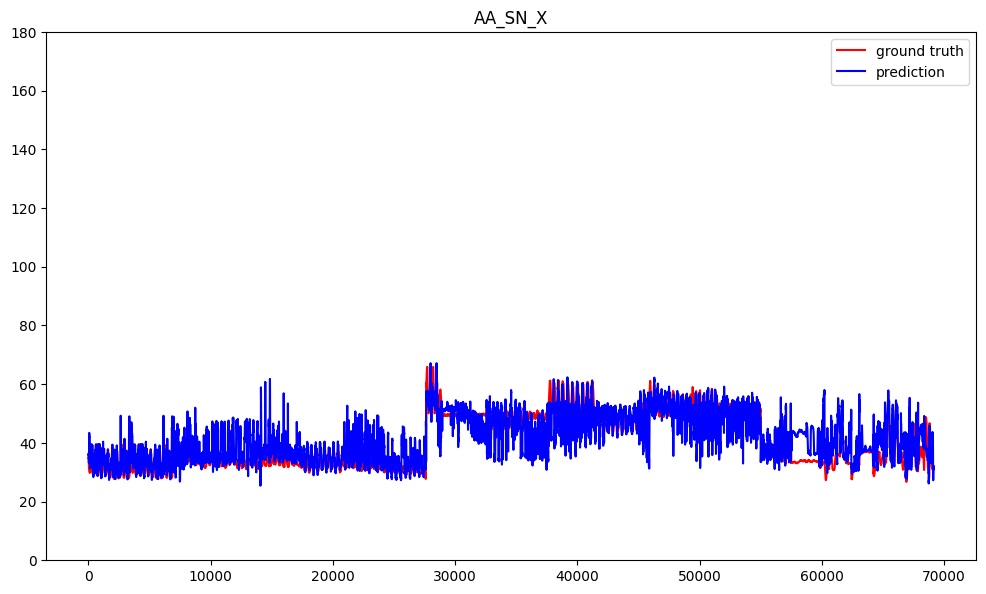

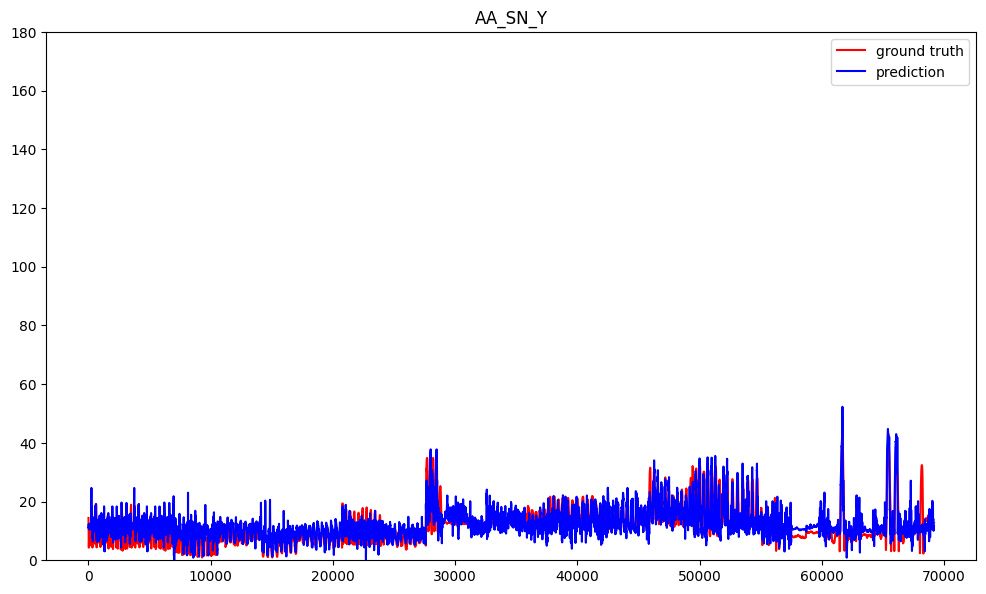

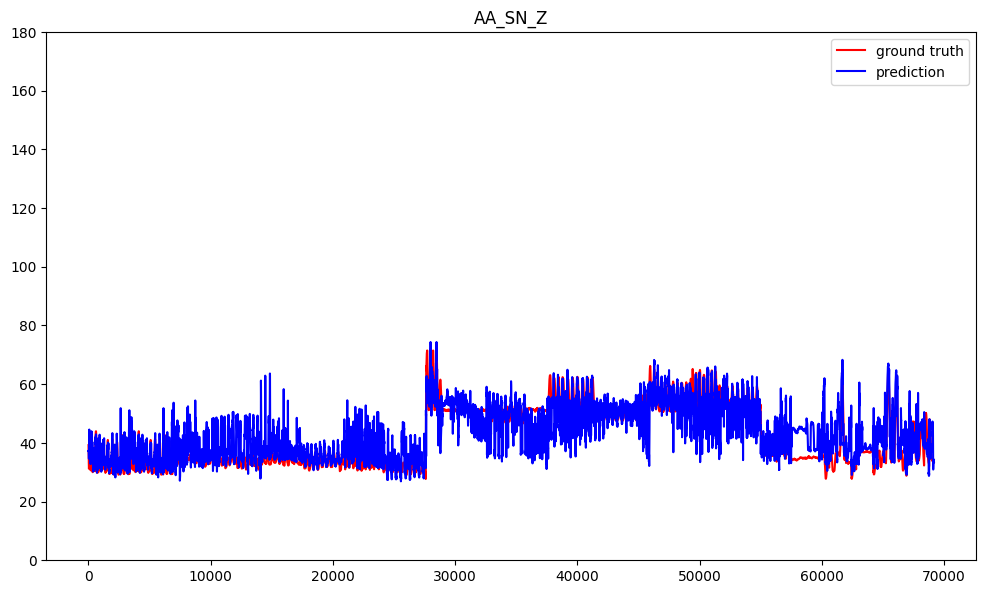

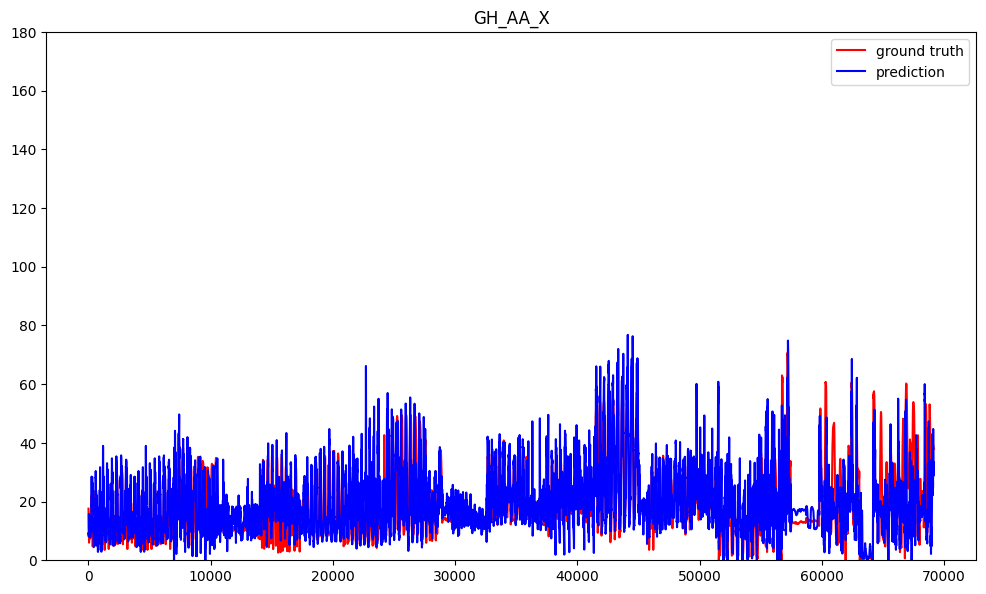

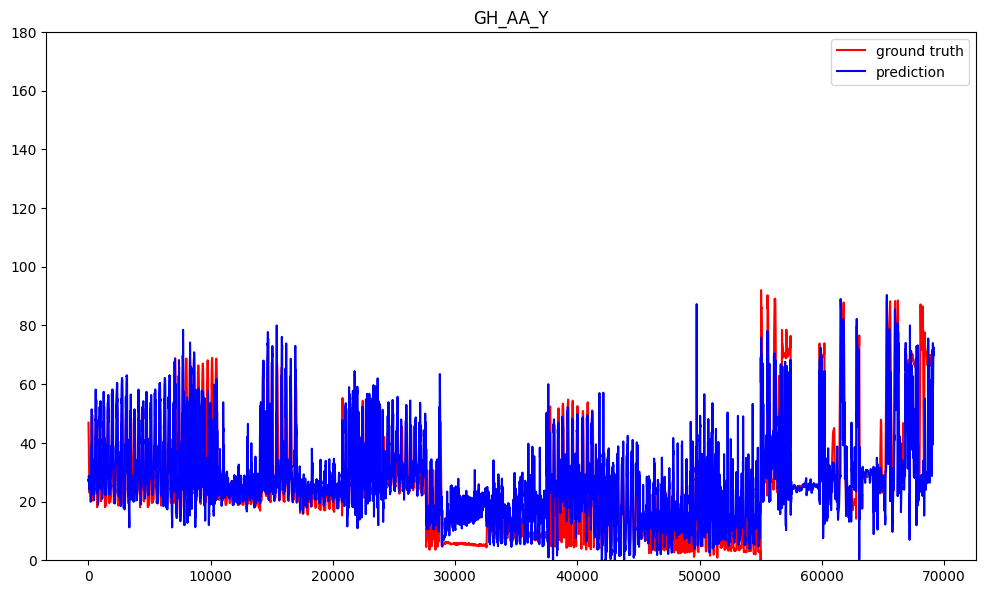

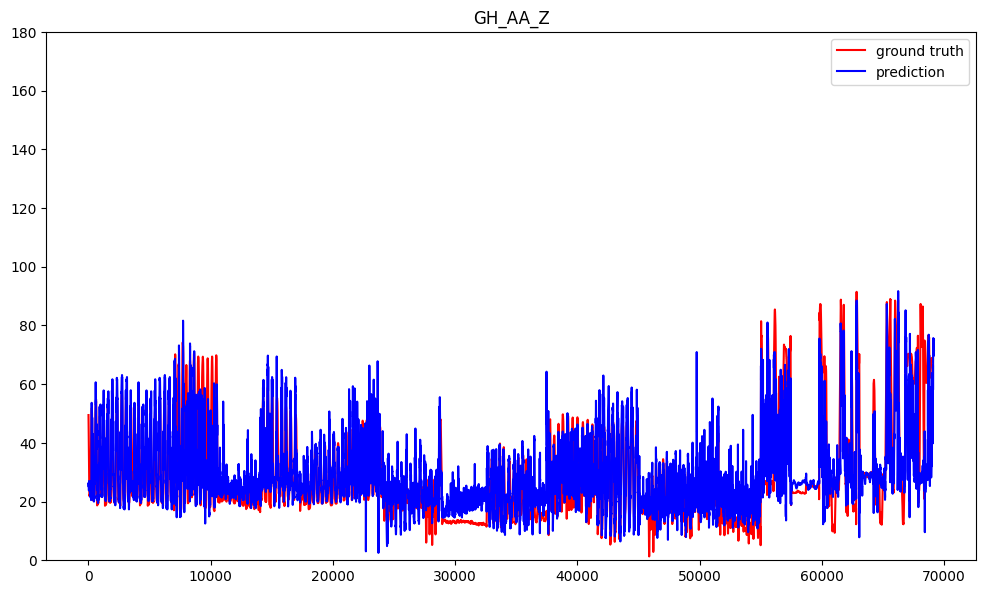

In [17]:
import json
import csv
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

def parse_args():
    """arguments"""
    config = {
    "data_dir": "./data/trainset/",
    "model_path": "./model/channel_temporal_attention-2021-09-08-11-31.ckpt",
    "output_path": "./result/output.csv",
    "window_length": 32,
    "d_channel": 128, 
    "d_temporal": 32,
    "dropout": 0.0,
    "batch_size": 1,
    }

    return config


def main(
    data_dir,
    model_path,
    output_path,
    window_length,
    d_channel,
    d_temporal, 
    dropout,
    batch_size
):
    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    dataset = Sensor2AngleDataset(data_dir, window_length)
    
    dataloader = DataLoader(
    dataset,
    batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    collate_fn=collate_batch,
    )
    print(f"[Info]: Finish loading data!",flush = True)
    
    model = Attention(d_channel, d_temporal, window_length, dropout)
    model.load_state_dict(torch.load(model_path))
#     model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    print(f"[Info]: Finish creating model!",flush = True)
    
    criterion = nn.MSELoss()
    loss_list = []
    results = [["Label", "Preds"]]
    angles_list = []
    preds_list = []
    for sensor, angle in tqdm(dataloader):
        with torch.no_grad():
#             sensor = sensor.to(device)
            sensor = sensor
            outs = model(sensor)
            preds = outs.cpu()
            results.append([angle.numpy(), preds.numpy()])
            angles_list.append(angle.numpy())
            preds_list.append(preds.numpy())
            
            loss = criterion(preds, angle)
            loss_list.append(loss.item())

    with open(output_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(results)
        print(f"[Info]: Finish save results!",flush = True)
        
    # visualization
    print('RMSE loss:', np.sqrt(np.array(loss_list).mean()))
    preds_list = np.array(preds_list).squeeze()
    angles_list = np.array(angles_list).squeeze()
    visualize_result(angles_list, preds_list)

    
def visualize_result(label, predict):
    for i in range(6):
        figure(figsize=(12, 7), dpi=100)
        plt.plot(label[:,i], color='r', label='ground truth')
        plt.plot(predict[:,i], color='b', label='prediction')
        plt.title(label_names[i])
        axes = plt.gca()
        axes.set_ylim([0,180])
        plt.legend()
        plt.savefig(f'result/test/trainDataset{label_names[i]}.png')
    plt.show()
    
if __name__ == "__main__":
    main(**parse_args())

# Inference

In [ ]:
import json
import csv
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

def parse_args():
    """arguments"""
    config = {
    "data_dir": "./data/testset/normal.npy",
    "model_path": "./model/attention-2021-08-30-14-29.ckpt",
    "output_path": "./result/output.csv",
    "window_length": 30,
    "d_model": 80, 
    "dropout": 0.0,
    }

    return config


def main(
    data_dir,
    model_path,
    output_path,
    window_length,
    d_model, 
    dropout
):
    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    dataset = Sensor2AngleTestDataset(data_dir, window_length)
    dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    )
    
    print(f"[Info]: Finish loading data!",flush = True)
    
    model = Attention(d_model, dropout).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    print(f"[Info]: Finish creating model!",flush = True)
    
    preds_list = []
    for sensor in tqdm(dataloader):
        with torch.no_grad():
            sensor = sensor.to(device).float()
            outs = model(sensor)
            preds = outs.cpu()
            preds_list.append(preds.numpy())
    # visualization
    preds_list = np.array(preds_list).squeeze()
    sensor_list = np.load(data_dir)
    visualize_result(sensor_list, preds_list, dataDir=data_dir)

    
def visualize_result(sensor, predict, dataDir):
    figure(figsize=(12, 7), dpi=100)
    axes = plt.gca()
    axes.set_ylim([0,180])
    for i in range(6):
        plt.plot(predict[:,i], label=label_names[i])
        plt.legend()
    for j in range(5):
        plt.plot(sensor[:,j], color='b', label=label_names[j])
    plt.title(dataDir)
    savefigPath = os.path.join('./result/fading/',
                               os.path.basename(dataDir).replace('.npy', '.png'))
    plt.savefig(savefigPath)
    plt.show()

if __name__ == "__main__":
    main(**parse_args())